In [97]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import time
from datetime import datetime, timedelta
import plotly.graph_objects as go
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from scipy import stats
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras import regularizers
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import itertools  



In [98]:
# google trends data
data = pd.read_csv('selected_google_trends_volume.csv')
#volume data
df = pd.read_csv('denoised_volume.csv')

In [99]:
data.head()

date  Football  Avon  We Buy Cars  Soccer Laduma  The Courier Guy  \
0  2018-12-30        82    34            7             12                0   
1  2018-12-31        53    29            5             12                0   
2  2019-01-01        78    39            9             12                0   
3  2019-01-02        64    42           11             16                0   
4  2019-01-03        64    45           13             16                0   

   Vodacom  Property24  Standard Bank  Game  ...  Goojara movies  Samsung  \
0       46          23             30    11  ...               0       59   
1       58          22             55    13  ...               0       59   
2       54          30             33    13  ...               0       62   
3       67          31             53    13  ...               0       67   
4       65          34             52    12  ...               0       64   

   Disney+  Huawei  DStv Stream  Guest House  AutoTrader  laptop  \
0       39      19            0           37          17      34   
1       21      18            0           36          15      31   
2       36      15            0           27          20      30   
3       32      21            0           28          22      47   
4       23      20            0           25          23      38   

   Cars for Sale  Nike  
0             25    55  
1             20    49  
2             27    49  
3             30    54  
4             27    43  

[5 rows x 25 columns]

In [100]:
df.head()

Date  Volume_SG      lag_1      lag_2
0  2018-12-31  16.977765  16.821507  16.821507
1  2019-01-01  17.131434  16.977765  16.977765
2  2019-01-02  17.282514  17.131434  17.131434
3  2019-01-03  17.431005  17.282514  17.282514
4  2019-01-04  17.576907  17.431005  17.431005

In [101]:
data.shape

(2365, 25)

In [102]:
df.shape

(2364, 4)

In [103]:
# missing data
data.isna().sum().sum()

0

In [104]:
data.columns

Index(['date', 'Football', 'Avon', 'We Buy Cars', 'Soccer Laduma',
       'The Courier Guy', 'Vodacom', 'Property24', 'Standard Bank', 'Game',
       'Gmail', 'MTN', 'Tickets', 'YouTube', 'Pick n Pay', 'Goojara movies',
       'Samsung', 'Disney+', 'Huawei', 'DStv Stream', 'Guest House',
       'AutoTrader', 'laptop', 'Cars for Sale', 'Nike'],
      dtype='object')

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             2365 non-null   object
 1   Football         2365 non-null   int64 
 2   Avon             2365 non-null   int64 
 3   We Buy Cars      2365 non-null   int64 
 4   Soccer Laduma    2365 non-null   int64 
 5   The Courier Guy  2365 non-null   int64 
 6   Vodacom          2365 non-null   int64 
 7   Property24       2365 non-null   int64 
 8   Standard Bank    2365 non-null   int64 
 9   Game             2365 non-null   int64 
 10  Gmail            2365 non-null   int64 
 11  MTN              2365 non-null   int64 
 12  Tickets          2365 non-null   int64 
 13  YouTube          2365 non-null   int64 
 14  Pick n Pay       2365 non-null   int64 
 15  Goojara movies   2365 non-null   int64 
 16  Samsung          2365 non-null   int64 
 17  Disney+          2365 non-null   

In [106]:
data.describe()

Football         Avon  We Buy Cars  Soccer Laduma  The Courier Guy  \
count  2365.000000  2365.000000  2365.000000    2365.000000      2365.000000   
mean     38.611839    25.906131    34.324736       2.685835         3.732770   
std      22.060884    15.633644    12.762151       2.822407         4.132283   
min       4.000000     0.000000     5.000000       0.000000         0.000000   
25%      16.000000    16.000000    24.000000       1.000000         0.000000   
50%      40.000000    22.000000    37.000000       2.000000         4.000000   
75%      53.000000    33.000000    45.000000       3.000000         6.000000   
max     100.000000   100.000000    63.000000      19.000000        21.000000   

           Vodacom   Property24  Standard Bank         Game        Gmail  ...  \
count  2365.000000  2365.000000    2365.000000  2365.000000  2365.000000  ...   
mean     43.773784    35.380973      46.461734    15.279915    55.874419  ...   
std      16.012685    20.808832      18.833357     5.164334    23.374731  ...   
min      16.000000     6.000000      11.000000     6.000000    10.000000  ...   
25%      29.000000    17.000000      32.000000    12.000000    36.000000  ...   
50%      43.000000    30.000000      43.000000    14.000000    54.000000  ...   
75%      56.000000    53.000000      61.000000    18.000000    78.000000  ...   
max     100.000000   100.000000     100.000000    65.000000   100.000000  ...   

       Goojara movies      Samsung      Disney+      Huawei  DStv Stream  \
count     2365.000000  2365.000000  2365.000000  2365.00000  2365.000000   
mean         2.224101    56.909091    50.083298    37.84482     3.876533   
std          2.251830    16.371112    21.557724     9.20669     6.902755   
min          0.000000    24.000000     4.000000    15.00000     0.000000   
25%          0.000000    46.000000    36.000000    32.00000     0.000000   
50%          2.000000    54.000000    52.000000    37.00000     0.000000   
75%          4.000000    71.000000    65.000000    42.00000     7.000000   
max         12.000000   100.000000   100.000000   100.00000    48.000000   

       Guest House   AutoTrader       laptop  Cars for Sale         Nike  
count  2365.000000  2365.000000  2365.000000    2365.000000  2365.000000  
mean     31.177590    27.659197    47.431290      20.467230    50.599577  
std       8.587398     5.241999    14.635042       5.034681    15.835205  
min       0.000000    11.000000    16.000000      10.000000    20.000000  
25%      26.000000    25.000000    38.000000      16.000000    38.000000  
50%      32.000000    28.000000    45.000000      20.000000    49.000000  
75%      37.000000    31.000000    54.000000      24.000000    62.000000  
max      57.000000    44.000000   100.000000      36.000000   100.000000  

[8 rows x 24 columns]

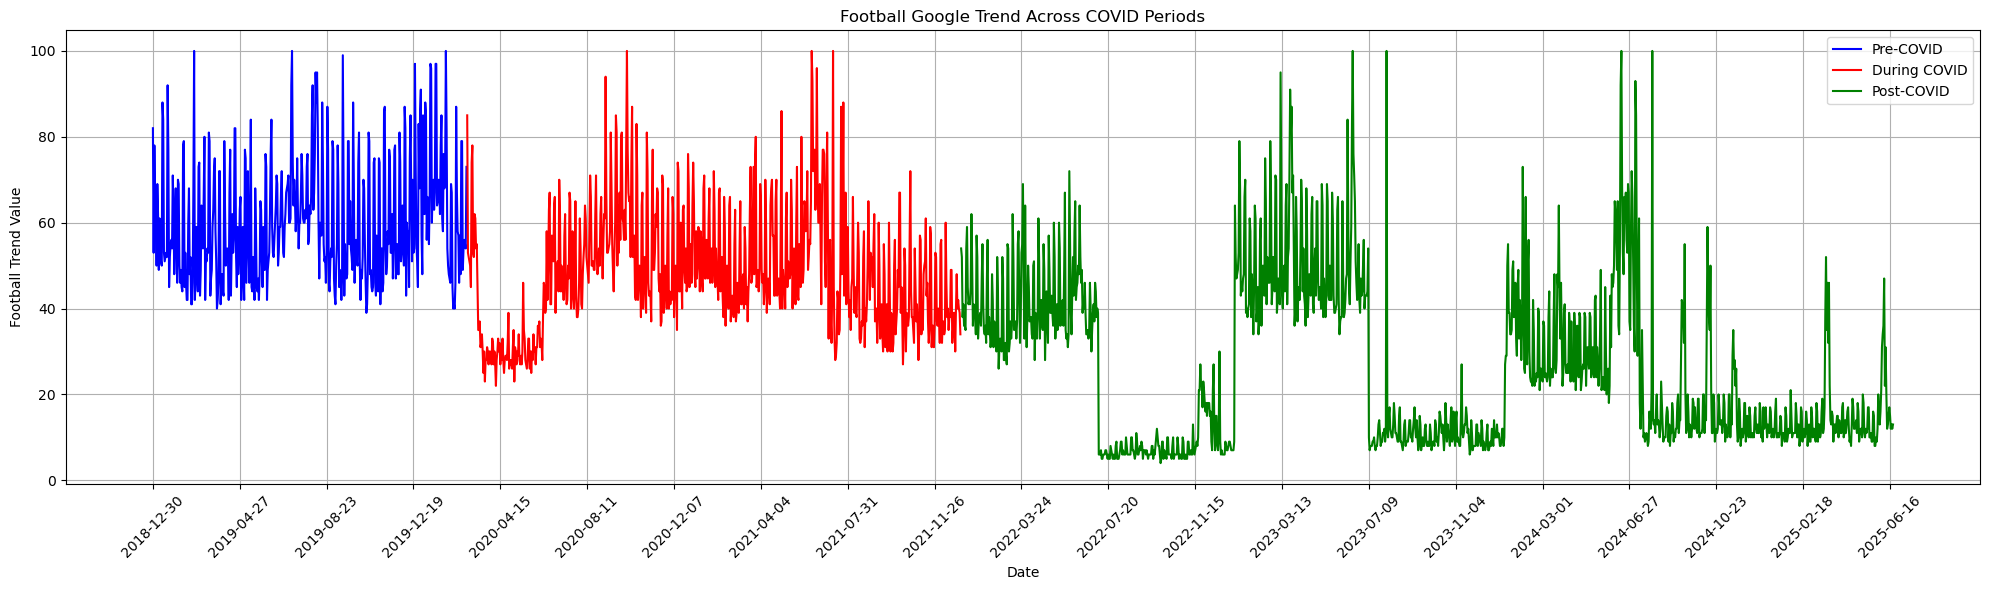

In [107]:
# List of Google Trends features
features = ['Football']
# Define periods
pre_covid_end = '2020-02-29'
covid_start = '2020-03-01'
covid_end = '2021-12-31'
post_covid_start = '2022-01-01'

# Split data
data_pre_covid = data[data['date'] <= pre_covid_end]
data_covid = data[(data['date'] >= covid_start) & (data['date'] <= covid_end)]
data_post_covid = data[data['date'] >= post_covid_start]

# Loop through features
for feature in features:
    plt.figure(figsize=(20,6))
    plt.plot(data_pre_covid['date'], data_pre_covid[feature], label='Pre-COVID', color='blue')
    plt.plot(data_covid['date'], data_covid[feature], label='During COVID', color='red')
    plt.plot(data_post_covid['date'], data_post_covid[feature], label='Post-COVID', color='green')
    
    plt.xlabel('Date')
    plt.ylabel(f'{feature} Trend Value')
    plt.title(f'{feature} Google Trend Across COVID Periods')
    plt.legend()
    
    # Show all dates from the data on x-axis
    plt.xticks(data['date'][::max(1, len(data)//20)], rotation=45)  # show ~20 ticks evenly
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()


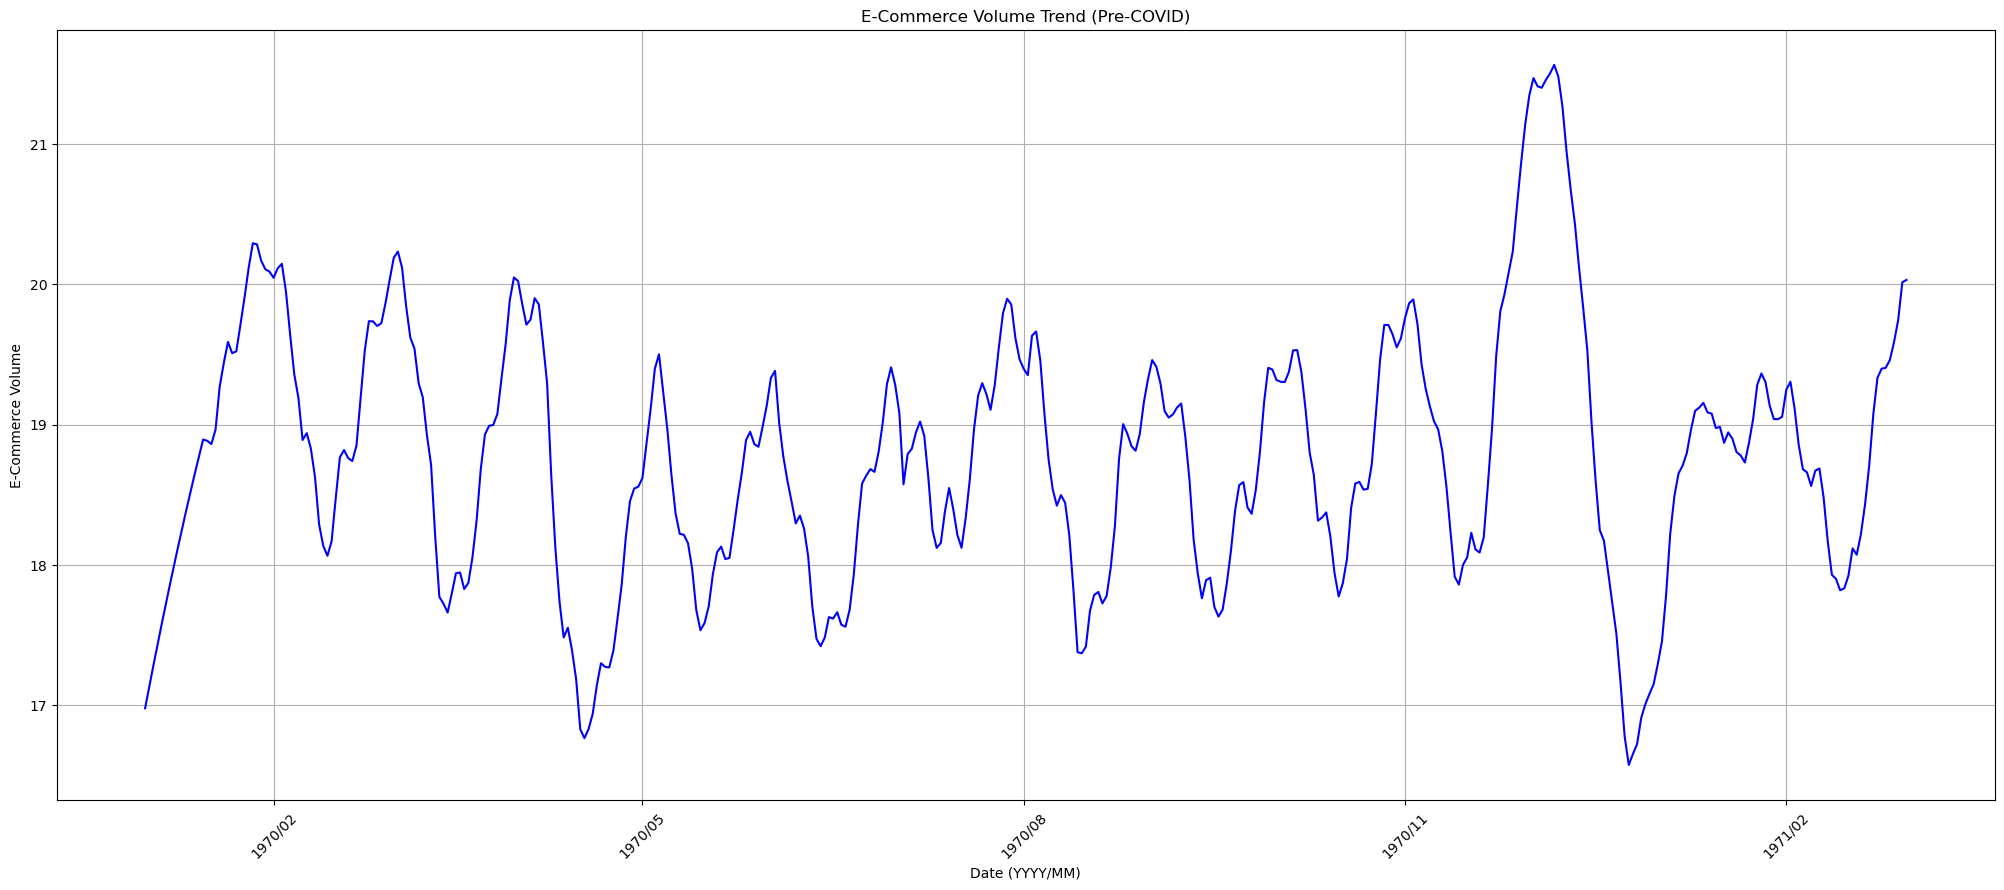

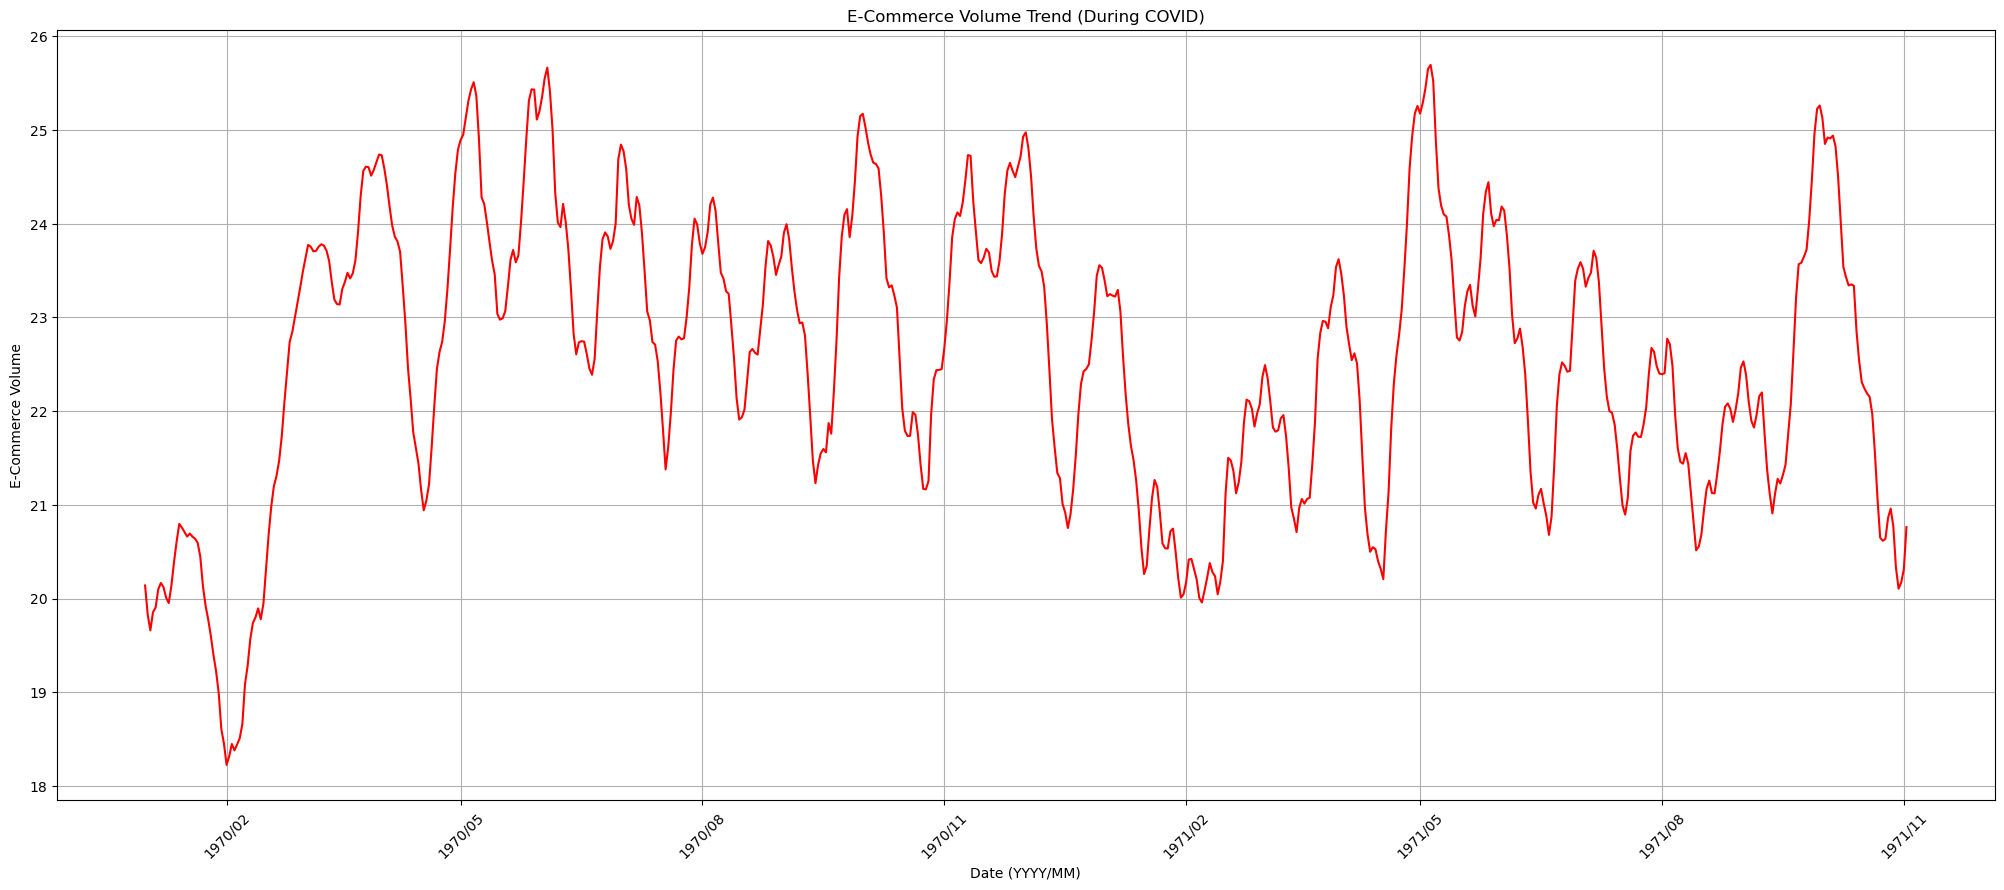

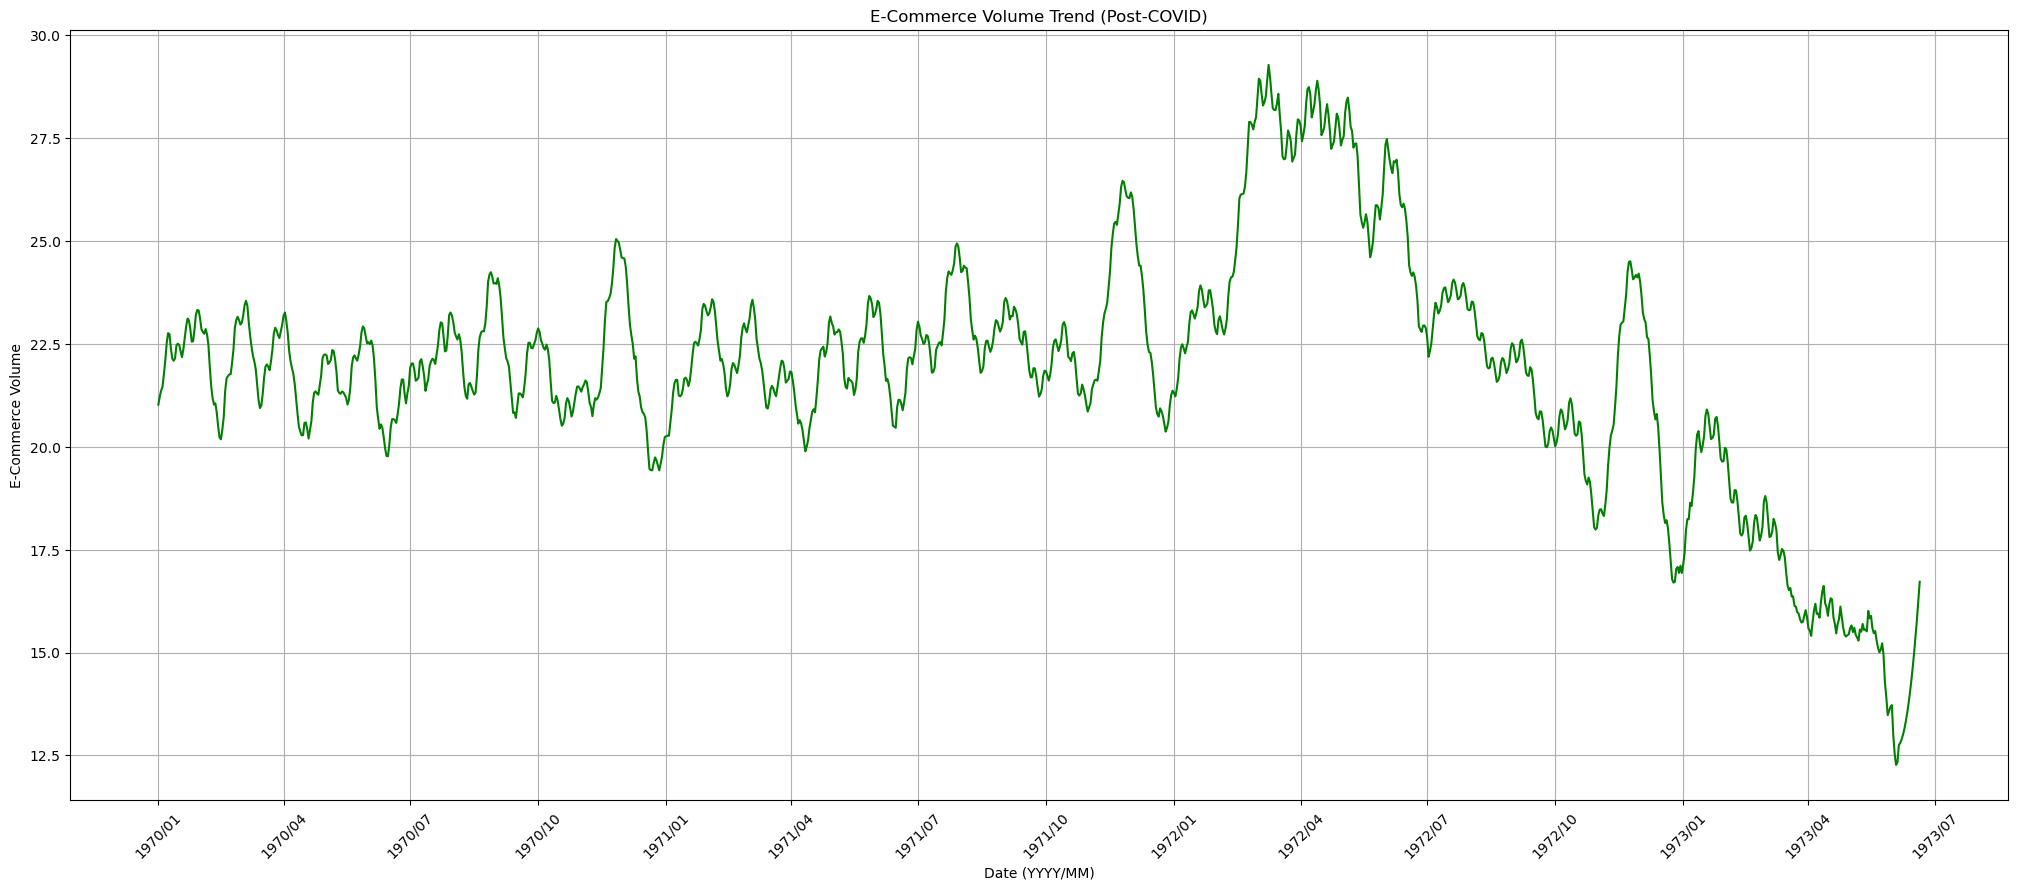

In [108]:
# Define periods
pre_covid_end = '2020-02-29'
covid_start = '2020-03-01'
covid_end = '2021-12-31'
post_covid_start = '2022-01-01'

# Split data
df_pre_covid = df[df['Date'] <= pre_covid_end]
df_covid = df[(df['Date'] >= covid_start) & (df['Date'] <= covid_end)]
df_post_covid = df[df['Date'] >= post_covid_start]

# Function to plot with YYYY/MM x-axis
def plot_volume(df_period, color, title):
    plt.figure(figsize=(25,10))
    plt.plot(df_period['Date'], df_period['Volume_SG'], color=color)
    plt.xlabel('Date (YYYY/MM)')
    plt.ylabel('E-Commerce Volume')
    plt.title(title)
    plt.grid(True)
    
    # Format x-axis to show year/month
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # every 3 months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
    plt.xticks(rotation=45)
    plt.show()

# Plot each period
plot_volume(df_pre_covid, 'blue', 'E-Commerce Volume Trend (Pre-COVID)')
plot_volume(df_covid, 'red', 'E-Commerce Volume Trend (During COVID)')
plot_volume(df_post_covid, 'green', 'E-Commerce Volume Trend (Post-COVID)')


In [109]:
data.columns

Index(['date', 'Football', 'Avon', 'We Buy Cars', 'Soccer Laduma',
       'The Courier Guy', 'Vodacom', 'Property24', 'Standard Bank', 'Game',
       'Gmail', 'MTN', 'Tickets', 'YouTube', 'Pick n Pay', 'Goojara movies',
       'Samsung', 'Disney+', 'Huawei', 'DStv Stream', 'Guest House',
       'AutoTrader', 'laptop', 'Cars for Sale', 'Nike'],
      dtype='object')

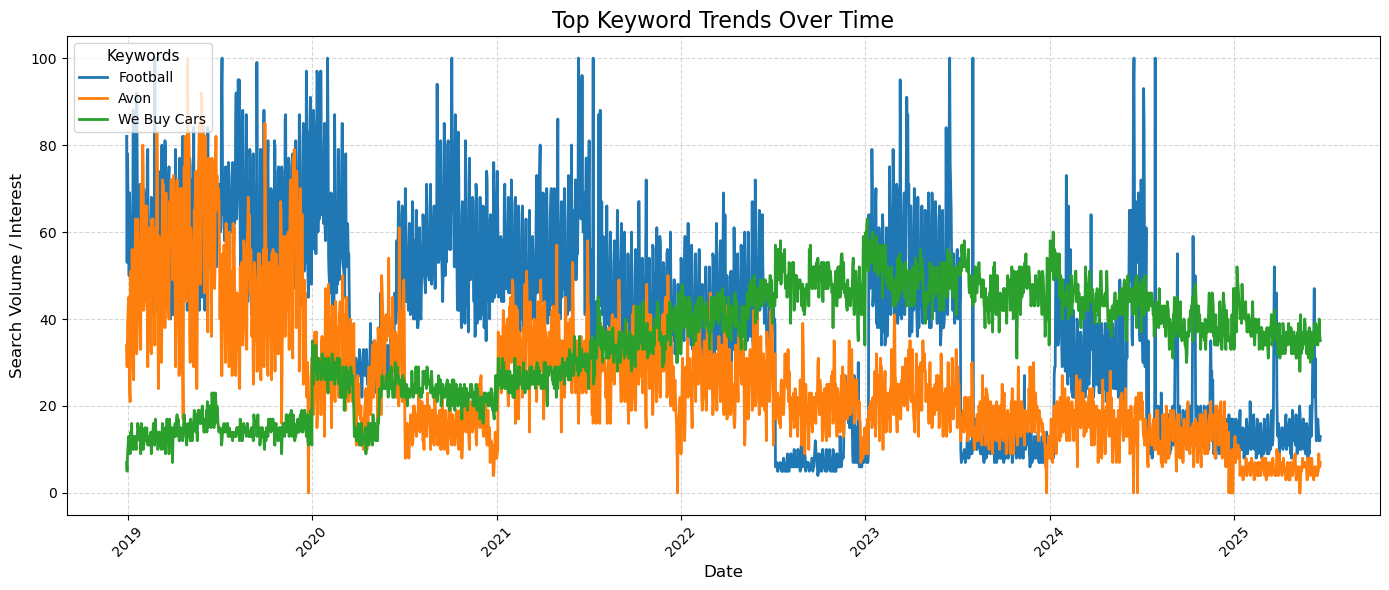

In [110]:
top_features = ['Football', 'Avon', 'We Buy Cars']

# Ensure datetime index
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)

# Keep only top features
df_v = data[top_features].fillna(0)

# Resample daily
df_v = df_v.resample('D').interpolate()

# Plot
plt.figure(figsize=(14, 6))
for feature in top_features:
    plt.plot(df_v.index, df_v[feature], label=feature, linewidth=2)

plt.title('Top Keyword Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Volume / Interest', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Keywords", loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()


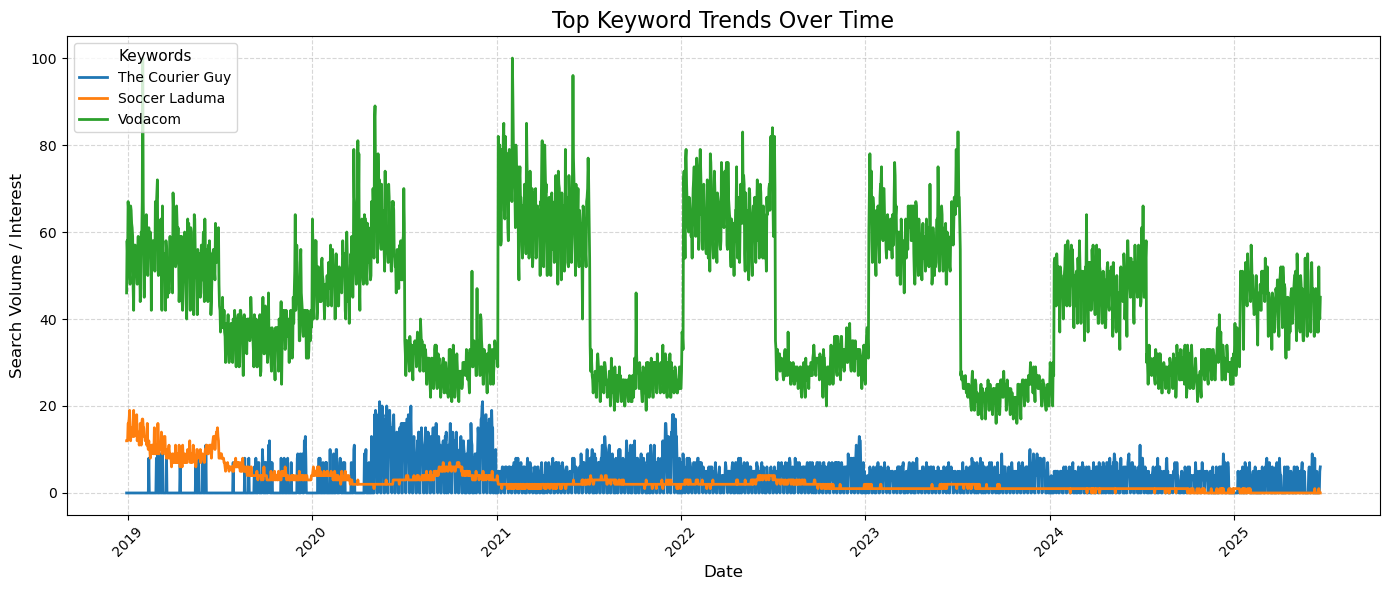

In [111]:
top_features = ['The Courier Guy','Soccer Laduma', 'Vodacom']

# Keep only top features
df_v = data[top_features].fillna(0)
# Plot
plt.figure(figsize=(14, 6))
for feature in top_features:
    plt.plot(df_v.index, df_v[feature], label=feature, linewidth=2)

plt.title('Top Keyword Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Volume / Interest', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Keywords", loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

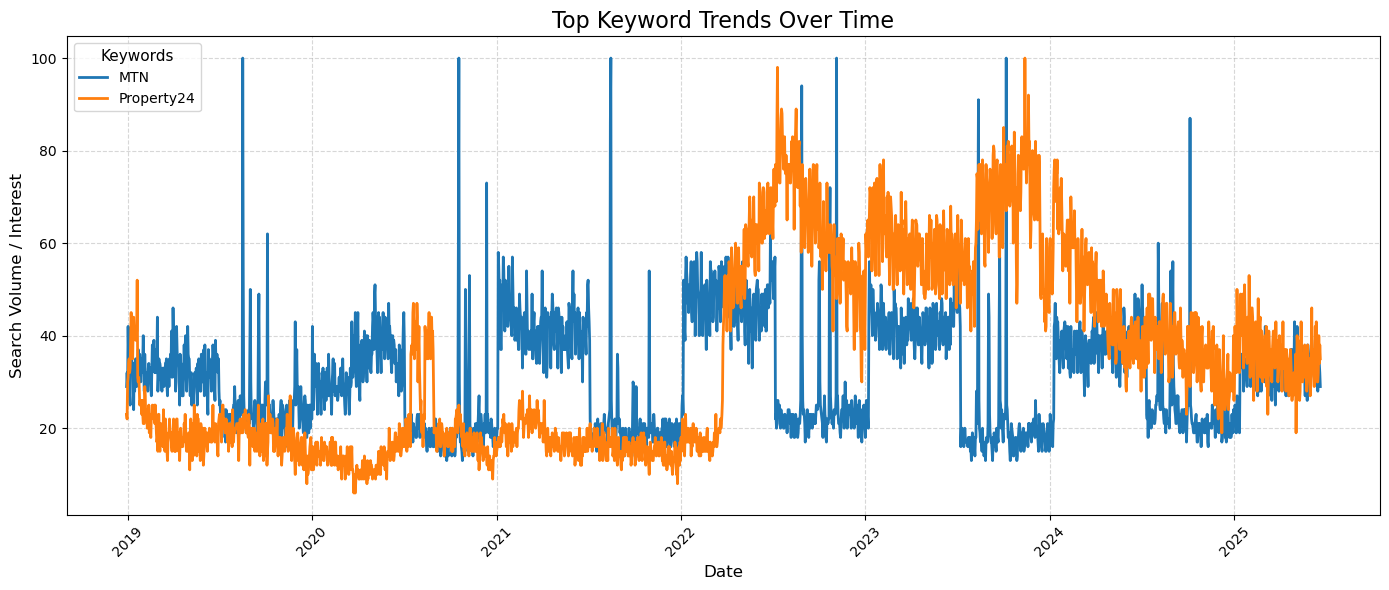

In [112]:
top_features = [ 'MTN', 'Property24']

# Keep only top features
df_v = data[top_features].fillna(0)
# Plot
plt.figure(figsize=(14, 6))
for feature in top_features:
    plt.plot(df_v.index, df_v[feature], label=feature, linewidth=2)

plt.title('Top Keyword Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Volume / Interest', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Keywords", loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

In [113]:
data.head()


Football  Avon  We Buy Cars  Soccer Laduma  The Courier Guy  \
date                                                                      
2018-12-30        82    34            7             12                0   
2018-12-31        53    29            5             12                0   
2019-01-01        78    39            9             12                0   
2019-01-02        64    42           11             16                0   
2019-01-03        64    45           13             16                0   

            Vodacom  Property24  Standard Bank  Game  Gmail  ...  \
date                                                         ...   
2018-12-30       46          23             30    11     17  ...   
2018-12-31       58          22             55    13     20  ...   
2019-01-01       54          30             33    13     17  ...   
2019-01-02       67          31             53    13     27  ...   
2019-01-03       65          34             52    12     32  ...   

            Goojara movies  Samsung  Disney+  Huawei  DStv Stream  \
date                                                                
2018-12-30               0       59       39      19            0   
2018-12-31               0       59       21      18            0   
2019-01-01               0       62       36      15            0   
2019-01-02               0       67       32      21            0   
2019-01-03               0       64       23      20            0   

            Guest House  AutoTrader  laptop  Cars for Sale  Nike  
date                                                              
2018-12-30           37          17      34             25    55  
2018-12-31           36          15      31             20    49  
2019-01-01           27          20      30             27    49  
2019-01-02           28          22      47             30    54  
2019-01-03           25          23      38             27    43  

[5 rows x 24 columns]

In [114]:
# Features to check
features = data.columns.tolist()


# Dictionary to store outlier indices
outlier_indices = {}

# Detect outliers for each feature
for feature in features:
    series = data[feature]
    
    # Compute z-scores
    z_scores = np.abs(stats.zscore(series))
    
    # Boolean mask for outliers
    mask = z_scores > 3
    
    # Get the index of outlier rows
    outliers = series[mask].index
    outlier_indices[feature] = outliers

# Print outlier counts
total_outliers = 0
for feature in features:
    num_outliers = len(outlier_indices[feature])
    print(f"{feature}: {num_outliers} outliers")
    total_outliers += num_outliers

print(f"\nTotal outliers across all selected features: {total_outliers}")


Football: 0 outliers
Avon: 33 outliers
We Buy Cars: 0 outliers
Soccer Laduma: 57 outliers
The Courier Guy: 33 outliers
Vodacom: 3 outliers
Property24: 2 outliers
Standard Bank: 0 outliers
Game: 27 outliers
Gmail: 0 outliers
MTN: 11 outliers
Tickets: 34 outliers
YouTube: 1 outliers
Pick n Pay: 19 outliers
Goojara movies: 16 outliers
Samsung: 0 outliers
Disney+: 0 outliers
Huawei: 20 outliers
DStv Stream: 35 outliers
Guest House: 7 outliers
AutoTrader: 2 outliers
laptop: 27 outliers
Cars for Sale: 1 outliers
Nike: 7 outliers

Total outliers across all selected features: 335


In [115]:
data_clean = data.copy()
for feature, indices in outlier_indices.items():
    # Use median to replace outliers
    median_value = data_clean[feature].median()
    data_clean.loc[indices, feature] = median_value

print("Outliers replaced with median values.")

Outliers replaced with median values.


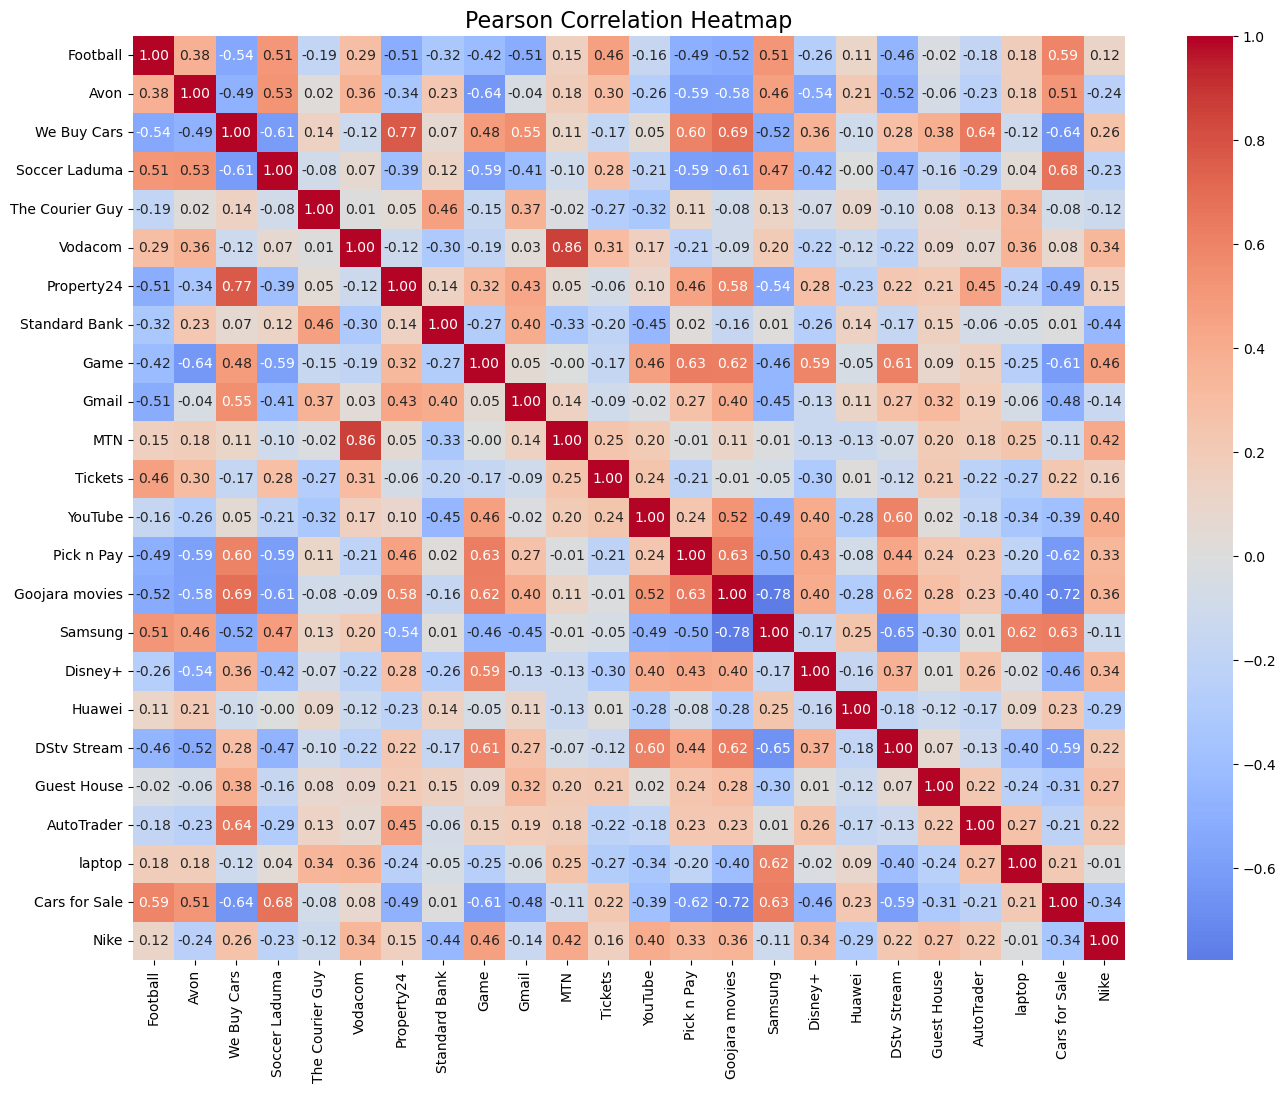

In [116]:
# Compute Pearson correlation matrix
corr = data_clean.corr(method='pearson', numeric_only=True)

#  heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True,cmap='coolwarm', center=0, fmt=".2f")
plt.title("Pearson Correlation Heatmap", fontsize=16)
plt.show()

In [117]:
# checking for stationarity using ADF test
def check_stationarity(series):
    result = adfuller(series)
    p_value = result[1]
    return p_value

stationarity_results = {}

for col in data_clean.columns:
    p_val = check_stationarity(data[col])
    stationarity_results[col] = p_val

# Show which columns are stationary (p-value < 0.05)
stationary_cols = [col for col, p in stationarity_results.items() if p < 0.05]

print("Stationary columns:", stationary_cols)

# And non-stationary columns
non_stationary_cols = [col for col, p in stationarity_results.items() if p >= 0.05]
print("Non-stationary columns:", non_stationary_cols)


Stationary columns: ['Soccer Laduma', 'The Courier Guy', 'Vodacom', 'MTN', 'Tickets', 'Disney+', 'Huawei', 'Nike']
Non-stationary columns: ['Football', 'Avon', 'We Buy Cars', 'Property24', 'Standard Bank', 'Game', 'Gmail', 'YouTube', 'Pick n Pay', 'Goojara movies', 'Samsung', 'DStv Stream', 'Guest House', 'AutoTrader', 'laptop', 'Cars for Sale']


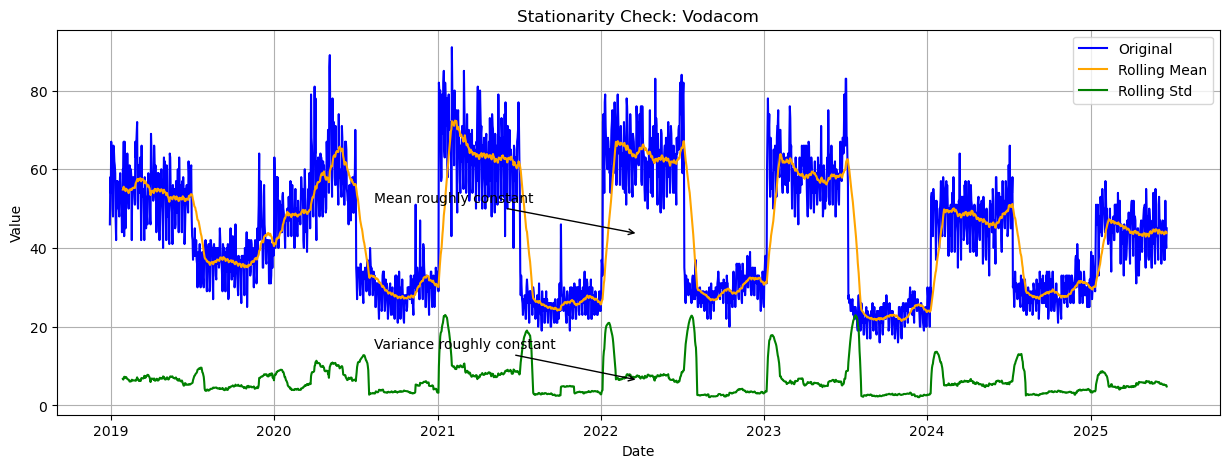

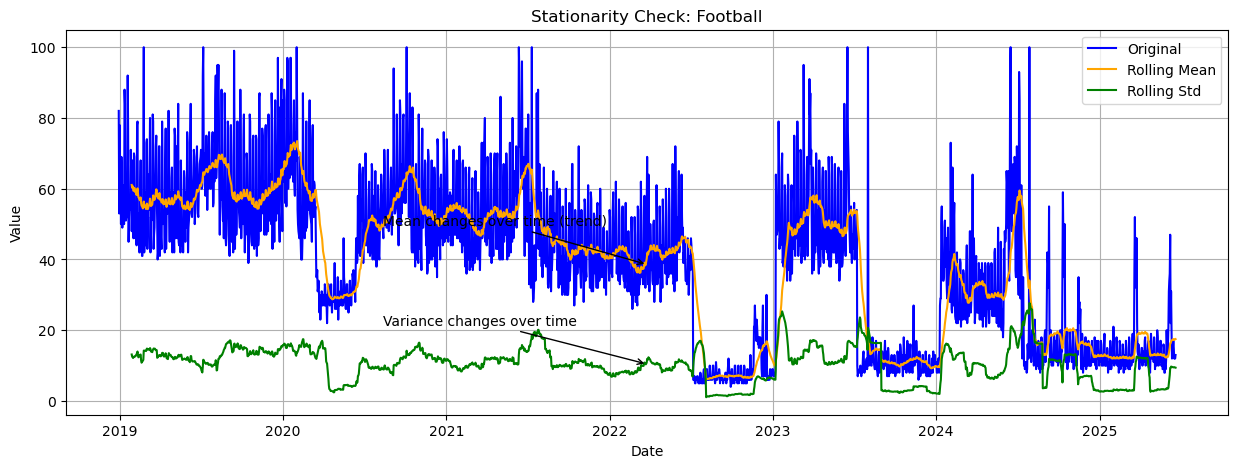

In [118]:
#  features
stationary_feature = 'Vodacom'
nonstationary_feature = 'Football'

def plot_stationarity_annotated(series, feature_name, window=30, stationary=True):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    
    plt.figure(figsize=(15,5))
    plt.plot(series, label='Original', color='blue')
    plt.plot(rolling_mean, label='Rolling Mean', color='orange')
    plt.plot(rolling_std, label='Rolling Std', color='green')
    plt.title(f"Stationarity Check: {feature_name}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
    
    # Annotate
    if stationary:
        plt.annotate('Mean roughly constant', xy=(series.index[len(series)//2], rolling_mean.mean()),
                     xytext=(series.index[len(series)//4], rolling_mean.mean()+series.std()*0.5),
                     arrowprops=dict(facecolor='black', arrowstyle='->'))
        plt.annotate('Variance roughly constant', xy=(series.index[len(series)//2], rolling_std.mean()),
                     xytext=(series.index[len(series)//4], rolling_std.mean()+series.std()*0.5),
                     arrowprops=dict(facecolor='black', arrowstyle='->'))
    else:
        plt.annotate('Mean changes over time (trend)', xy=(series.index[len(series)//2], rolling_mean.mean()),
                     xytext=(series.index[len(series)//4], rolling_mean.mean()+series.std()*0.5),
                     arrowprops=dict(facecolor='red', arrowstyle='->'))
        plt.annotate('Variance changes over time', xy=(series.index[len(series)//2], rolling_std.mean()),
                     xytext=(series.index[len(series)//4], rolling_std.mean()+series.std()*0.5),
                     arrowprops=dict(facecolor='red', arrowstyle='->'))

    plt.legend()
    plt.show()

# Plot stationary feature with annotations
plot_stationarity_annotated(data_clean[stationary_feature], stationary_feature, stationary=True)

# Plot non-stationary feature with annotations
plot_stationarity_annotated(data_clean[nonstationary_feature], nonstationary_feature, stationary=False)




In [119]:
data_clean.shape

(2365, 24)

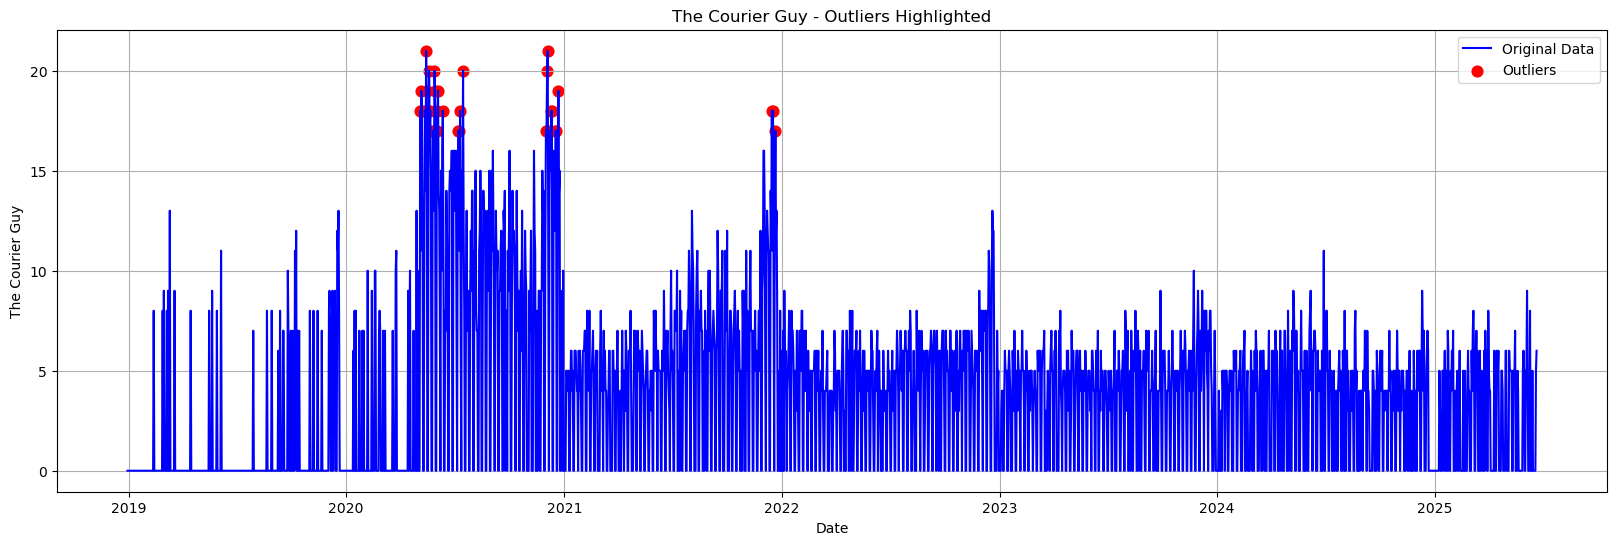

In [120]:
# Choose feature to plot
feature = 'The Courier Guy'

# Original series
series = data[feature]

# Outlier indices
outliers = outlier_indices[feature]

# Plot
plt.figure(figsize=(20,6))
plt.plot(series.index, series, label='Original Data', color='blue')
plt.scatter(outliers, series[outliers], color='red', label='Outliers', s=60)
plt.title(f"{feature} - Outliers Highlighted")
plt.xlabel("Date")
plt.ylabel(feature)
plt.legend()
plt.grid(True)
plt.show()

In [121]:
# Exclude 'date' column
numeric_features = data_clean.select_dtypes(include=['float64', 'int64']).columns

# Apply Savitzky-Golay filter to numeric features only
for feature in numeric_features:
    window_length = 31
    data_clean[feature] = savgol_filter(data_clean[feature], window_length=window_length, polyorder=2)

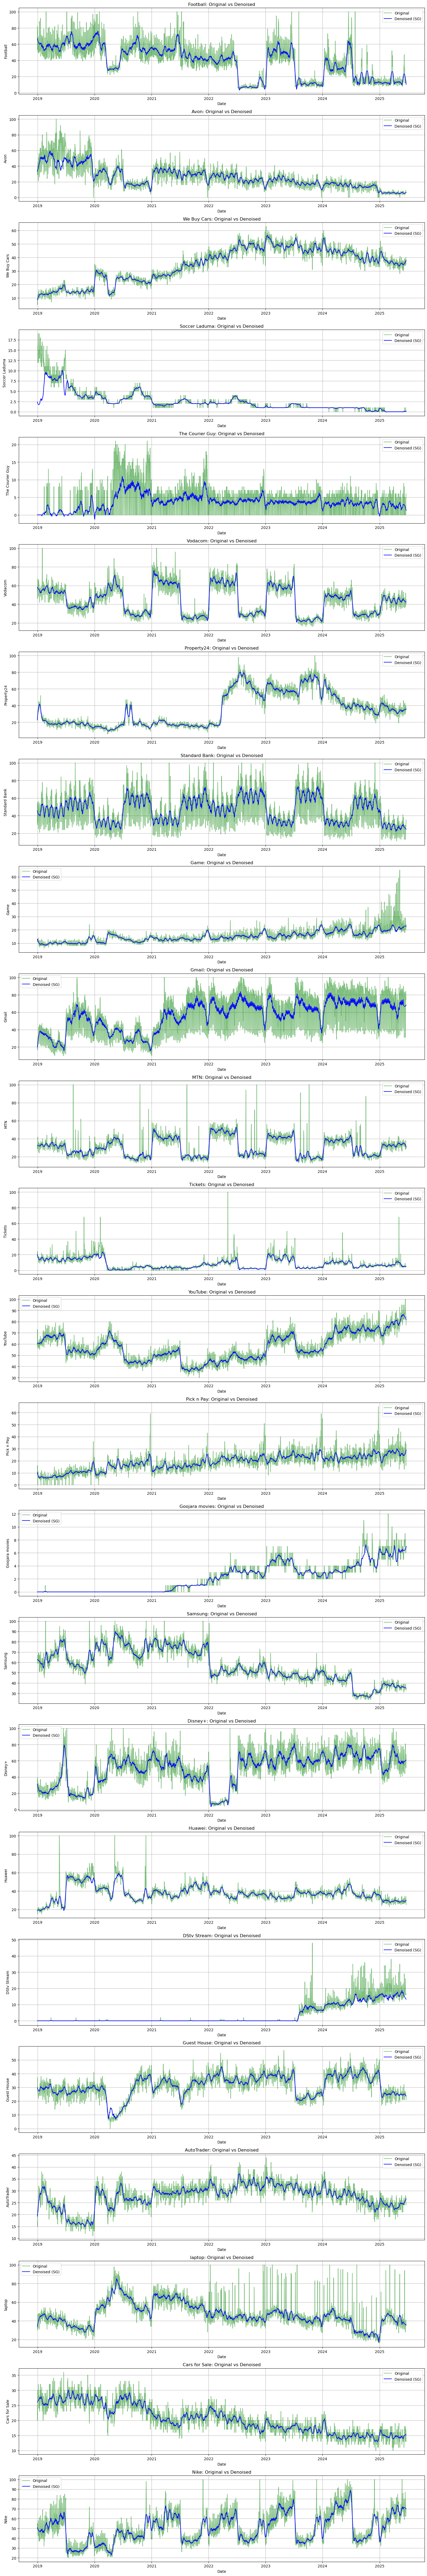

In [122]:
features = data_clean.select_dtypes(include=np.number).columns.tolist()

# Plot original vs cleaned for all features
plt.figure(figsize=(16, 4*len(features)))

for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(data.index, data[feature], color='green', alpha=0.5, label='Original')
    plt.plot(data_clean.index, data_clean[feature], color='blue', label='Denoised (SG)')
    plt.title(f"{feature}: Original vs Denoised")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# feature engeneering 

In [123]:
data_clean.shape

(2365, 24)

In [124]:
data_clean.head()

Football       Avon  We Buy Cars  Soccer Laduma  The Courier Guy  \
date                                                                            
2018-12-30  66.634531  33.418988     8.488636       2.395894              0.0   
2018-12-31  66.006012  34.237610     8.888490       2.258651              0.0   
2019-01-01  65.403431  35.051416     9.271418       2.136879              0.0   
2019-01-02  64.826787  35.860406     9.637420       2.030579              0.0   
2019-01-03  64.276082  36.664579     9.986498       1.939751              0.0   

              Vodacom  Property24  Standard Bank       Game      Gmail  ...  \
date                                                                    ...   
2018-12-30  58.041789   23.209311      45.506965  12.982771  20.112170  ...   
2018-12-31  57.793109   25.648900      44.709604  12.617669  21.976026  ...   
2019-01-01  57.548953   27.913207      43.984559  12.270654  23.743071  ...   
2019-01-02  57.309323   30.002230      43.331828  11.941728  25.413303  ...   
2019-01-03  57.074219   31.915970      42.751413  11.630890  26.986723  ...   

            Goojara movies    Samsung    Disney+     Huawei  DStv Stream  \
date                                                                       
2018-12-30             0.0  62.716276  30.824047  18.970674          0.0   
2018-12-31             0.0  62.627859  29.924560  19.043475          0.0   
2019-01-01             0.0  62.535196  29.071729  19.109614          0.0   
2019-01-02             0.0  62.438285  28.265553  19.169092          0.0   
2019-01-03             0.0  62.337127  27.506032  19.221908          0.0   

            Guest House  AutoTrader     laptop  Cars for Sale       Nike  
date                                                                      
2018-12-30    29.757331   19.314883  34.126466      25.987170  50.685850  
2018-12-31    29.386510   20.080132  35.018915      26.101026  50.255938  
2019-01-01    29.046380   20.819886  35.876679      26.211647  49.850865  
2019-01-02    28.736940   21.534144  36.699757      26.319031  49.470629  
2019-01-03    28.458191   22.222907  37.488151      26.423180  49.115232  

[5 rows x 24 columns]

In [125]:
df.shape

(2364, 4)

In [126]:
df['Date'] = pd.to_datetime(df['Date'])

# Set 'date' as index
df.set_index('Date', inplace=True)

# Check 
df.head()

Volume_SG      lag_1      lag_2
Date                                       
2018-12-31  16.977765  16.821507  16.821507
2019-01-01  17.131434  16.977765  16.977765
2019-01-02  17.282514  17.131434  17.131434
2019-01-03  17.431005  17.282514  17.282514
2019-01-04  17.576907  17.431005  17.431005

In [127]:
# Count missing values per column
missing_per_column = data_clean.isna().sum()
print(missing_per_column)

# Total missing values in the whole DataFrame
total_missing = missing_per_column.sum()
print(f'Total missing values: {total_missing}')

Football           0
Avon               0
We Buy Cars        0
Soccer Laduma      0
The Courier Guy    0
Vodacom            0
Property24         0
Standard Bank      0
Game               0
Gmail              0
MTN                0
Tickets            0
YouTube            0
Pick n Pay         0
Goojara movies     0
Samsung            0
Disney+            0
Huawei             0
DStv Stream        0
Guest House        0
AutoTrader         0
laptop             0
Cars for Sale      0
Nike               0
dtype: int64
Total missing values: 0


In [128]:
data_clean = data_clean.dropna()
print(f"Shape after dropping missing values: {data_clean.shape}")


Shape after dropping missing values: (2365, 24)


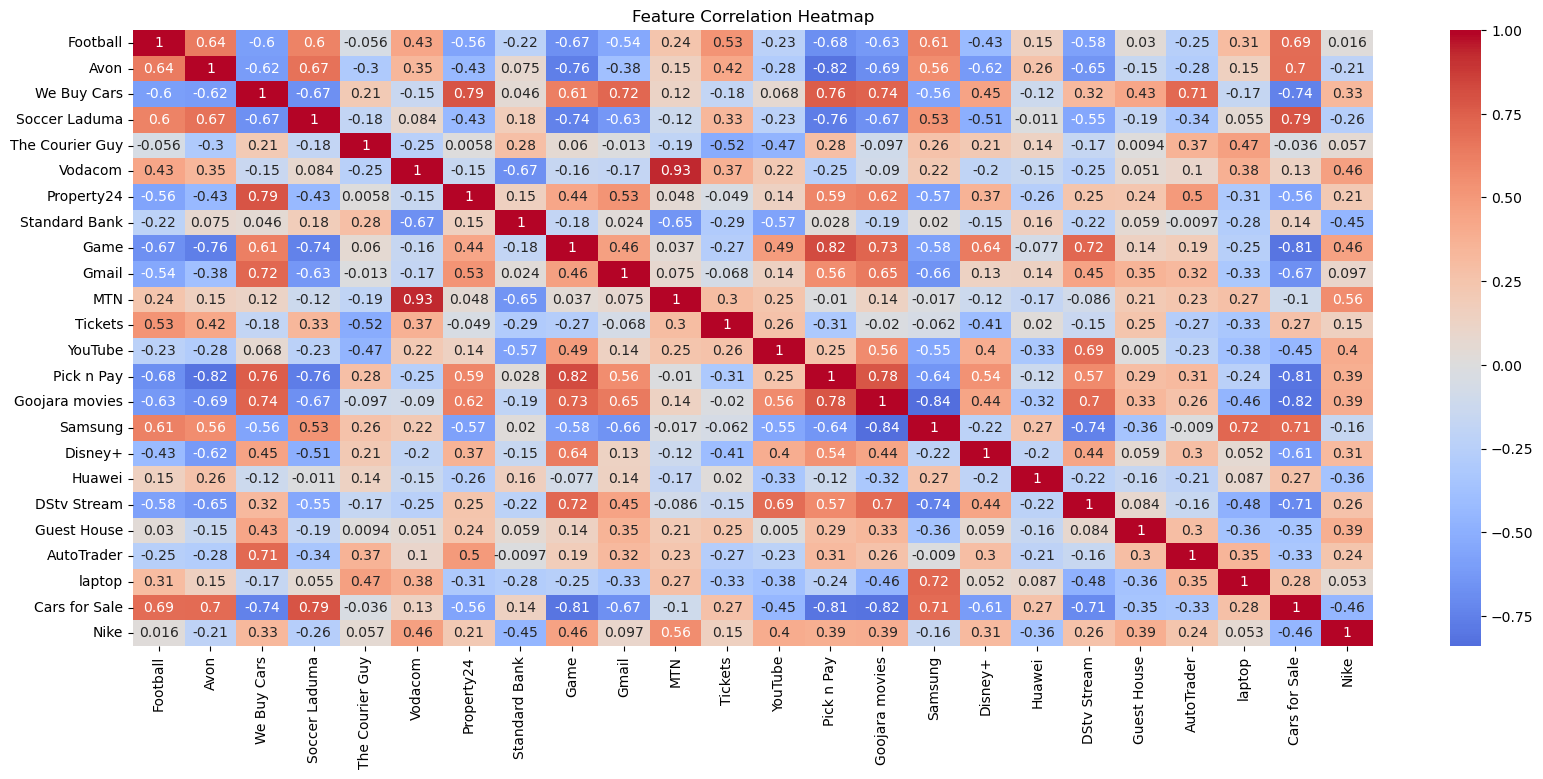

In [129]:
# --- Correlation Heatmap of Features ---
plt.figure(figsize=(20,8))
sns.heatmap(data_clean.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [130]:
'''features_target = df.select_dtypes(include=[np.number]).columns.tolist()

for feature in features_target:
    # Lag features
    df[f"{feature}_lag1"] = df[feature].shift(1)
    
    # Rolling window features
    df[f"{feature}_roll_mean3"] = df[feature].shift(1).rolling(window=3).mean()
    df[f"{feature}_roll_std3"]  = df[feature].shift(1).rolling(window=3).std()

# Time features from index
df["dayofweek"] = df.index.dayofweek
df["month"]     = df.index.month

# Cyclical encoding
df["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"]/7)
df["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"]/7)
df["month_sin"]     = np.sin(2 * np.pi * df["month"]/12)
df["month_cos"]     = np.cos(2 * np.pi * df["month"]/12)'''

'features_target = df.select_dtypes(include=[np.number]).columns.tolist()\n\nfor feature in features_target:\n    # Lag features\n    df[f"{feature}_lag1"] = df[feature].shift(1)\n\n    # Rolling window features\n    df[f"{feature}_roll_mean3"] = df[feature].shift(1).rolling(window=3).mean()\n    df[f"{feature}_roll_std3"]  = df[feature].shift(1).rolling(window=3).std()\n\n# Time features from index\ndf["dayofweek"] = df.index.dayofweek\ndf["month"]     = df.index.month\n\n# Cyclical encoding\ndf["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"]/7)\ndf["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"]/7)\ndf["month_sin"]     = np.sin(2 * np.pi * df["month"]/12)\ndf["month_cos"]     = np.cos(2 * np.pi * df["month"]/12)'

In [131]:
df= df.dropna()
print(f"Shape after dropping missing values: {df.shape}")

Shape after dropping missing values: (2364, 3)


In [132]:
df.head()

Volume_SG      lag_1      lag_2
Date                                       
2018-12-31  16.977765  16.821507  16.821507
2019-01-01  17.131434  16.977765  16.977765
2019-01-02  17.282514  17.131434  17.131434
2019-01-03  17.431005  17.282514  17.282514
2019-01-04  17.576907  17.431005  17.431005

In [133]:
df = df.rename(columns={
    "Date": "date",
})

In [134]:
merged_df = pd.concat([data_clean, df], axis=1)       

In [135]:
merged_df.head()

Football       Avon  We Buy Cars  Soccer Laduma  The Courier Guy  \
2018-12-30  66.634531  33.418988     8.488636       2.395894              0.0   
2018-12-31  66.006012  34.237610     8.888490       2.258651              0.0   
2019-01-01  65.403431  35.051416     9.271418       2.136879              0.0   
2019-01-02  64.826787  35.860406     9.637420       2.030579              0.0   
2019-01-03  64.276082  36.664579     9.986498       1.939751              0.0   

              Vodacom  Property24  Standard Bank       Game      Gmail  ...  \
2018-12-30  58.041789   23.209311      45.506965  12.982771  20.112170  ...   
2018-12-31  57.793109   25.648900      44.709604  12.617669  21.976026  ...   
2019-01-01  57.548953   27.913207      43.984559  12.270654  23.743071  ...   
2019-01-02  57.309323   30.002230      43.331828  11.941728  25.413303  ...   
2019-01-03  57.074219   31.915970      42.751413  11.630890  26.986723  ...   

               Huawei  DStv Stream  Guest House  AutoTrader     laptop  \
2018-12-30  18.970674          0.0    29.757331   19.314883  34.126466   
2018-12-31  19.043475          0.0    29.386510   20.080132  35.018915   
2019-01-01  19.109614          0.0    29.046380   20.819886  35.876679   
2019-01-02  19.169092          0.0    28.736940   21.534144  36.699757   
2019-01-03  19.221908          0.0    28.458191   22.222907  37.488151   

            Cars for Sale       Nike  Volume_SG      lag_1      lag_2  
2018-12-30      25.987170  50.685850        NaN        NaN        NaN  
2018-12-31      26.101026  50.255938  16.977765  16.821507  16.821507  
2019-01-01      26.211647  49.850865  17.131434  16.977765  16.977765  
2019-01-02      26.319031  49.470629  17.282514  17.131434  17.131434  
2019-01-03      26.423180  49.115232  17.431005  17.282514  17.282514  

[5 rows x 27 columns]

In [136]:
merged_df.shape

(2377, 27)

In [137]:
merged_df.isna().sum()

Football           12
Avon               12
We Buy Cars        12
Soccer Laduma      12
The Courier Guy    12
Vodacom            12
Property24         12
Standard Bank      12
Game               12
Gmail              12
MTN                12
Tickets            12
YouTube            12
Pick n Pay         12
Goojara movies     12
Samsung            12
Disney+            12
Huawei             12
DStv Stream        12
Guest House        12
AutoTrader         12
laptop             12
Cars for Sale      12
Nike               12
Volume_SG          13
lag_1              13
lag_2              13
dtype: int64

In [138]:
# Drop rows with any NaN values
merged_df_cleaned = merged_df.dropna()


In [139]:

# Check
print(merged_df_cleaned.shape)
print(merged_df.isna().sum().sum())
merged_df_cleaned.head()

(2352, 27)
327


Football       Avon  We Buy Cars  Soccer Laduma  The Courier Guy  \
2018-12-31  66.006012  34.237610     8.888490       2.258651              0.0   
2019-01-01  65.403431  35.051416     9.271418       2.136879              0.0   
2019-01-02  64.826787  35.860406     9.637420       2.030579              0.0   
2019-01-03  64.276082  36.664579     9.986498       1.939751              0.0   
2019-01-04  63.751315  37.463937    10.318650       1.864395              0.0   

              Vodacom  Property24  Standard Bank       Game      Gmail  ...  \
2018-12-31  57.793109   25.648900      44.709604  12.617669  21.976026  ...   
2019-01-01  57.548953   27.913207      43.984559  12.270654  23.743071  ...   
2019-01-02  57.309323   30.002230      43.331828  11.941728  25.413303  ...   
2019-01-03  57.074219   31.915970      42.751413  11.630890  26.986723  ...   
2019-01-04  56.843639   33.654427      42.243313  11.338141  28.463330  ...   

               Huawei  DStv Stream  Guest House  AutoTrader     laptop  \
2018-12-31  19.043475          0.0    29.386510   20.080132  35.018915   
2019-01-01  19.109614          0.0    29.046380   20.819886  35.876679   
2019-01-02  19.169092          0.0    28.736940   21.534144  36.699757   
2019-01-03  19.221908          0.0    28.458191   22.222907  37.488151   
2019-01-04  19.268063          0.0    28.210132   22.886174  38.241860   

            Cars for Sale       Nike  Volume_SG      lag_1      lag_2  
2018-12-31      26.101026  50.255938  16.977765  16.821507  16.821507  
2019-01-01      26.211647  49.850865  17.131434  16.977765  16.977765  
2019-01-02      26.319031  49.470629  17.282514  17.131434  17.131434  
2019-01-03      26.423180  49.115232  17.431005  17.282514  17.282514  
2019-01-04      26.524092  48.784672  17.576907  17.431005  17.431005  

[5 rows x 27 columns]

In [140]:
merged_df = merged_df_cleaned.dropna().reset_index(drop=True)

In [141]:
target = 'Volume_SG'
X = merged_df.drop(columns=[target])
y = merged_df[target]

In [142]:
# --- Train/test split (80/20) ---
train_size = int(len(merged_df) * 0.8)
test_size  = len(merged_df) - train_size

# Split features
X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]

# Split target
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)


X_train: (1881, 26) X_test: (471, 26)
y_train: (1881,) y_test: (471,)


In [143]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1,1))

In [144]:
def create_sequences(X, y, seq_length=30):
    X_seq, y_seq = [], []
    X = np.array(X)   # convert DataFrame → numpy
    y = np.array(y)   # convert DataFrame → numpy
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# --- Create sequences ---
seq_length = 30  # past 30 days
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq   = create_sequences(X_test_scaled, y_test_scaled, seq_length)

# --- Check shapes ---
print("X_train_seq:", X_train_seq.shape)
print("y_train_seq:", y_train_seq.shape)
print("X_test_seq:", X_test_seq.shape)
print("y_test_seq:", y_test_seq.shape)


X_train_seq: (1851, 30, 26)
y_train_seq: (1851, 1)
X_test_seq: (441, 30, 26)
y_test_seq: (441, 1)


# forecasting

# a. ARIMAX

In [145]:
exog_train = X_train
exog_test  = X_test

In [146]:
'''p = q = range(0, 3)  # simpler search
d = [0]               # target is stationary
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = 7   # rolling window =7

param_grid = list(itertools.product(p, d, q))
seasonal_grid = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, [seasonal_period]))

results = []

for order in param_grid:
    for seasonal_order in seasonal_grid:
        try:
            model = SARIMAX(y_train, exog=X_train,
                            order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            result = model.fit(disp=False)
            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'AIC': result.aic,
                'BIC': result.bic
            })
        except Exception as e:
            print(f"Failed: order={order}, seasonal_order={seasonal_order}, error={e}")
            continue

df_results = pd.DataFrame(results)

if not df_results.empty:
    best_model = df_results.sort_values('AIC').iloc[0]
    print(best_model)
else:
    print("No successful SARIMAX fits. Check data and parameter ranges.")'''


'p = q = range(0, 3)  # simpler search\nd = [0]               # target is stationary\nseasonal_p = seasonal_d = seasonal_q = range(0, 2)\nseasonal_period = 7   # rolling window =7\n\nparam_grid = list(itertools.product(p, d, q))\nseasonal_grid = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, [seasonal_period]))\n\nresults = []\n\nfor order in param_grid:\n    for seasonal_order in seasonal_grid:\n        try:\n            model = SARIMAX(y_train, exog=X_train,\n                            order=order, seasonal_order=seasonal_order,\n                            enforce_stationarity=False, enforce_invertibility=False)\n            result = model.fit(disp=False)\n            results.append({\n                \'order\': order,\n                \'seasonal_order\': seasonal_order,\n                \'AIC\': result.aic,\n                \'BIC\': result.bic\n            })\n        except Exception as e:\n            print(f"Failed: order={order}, seasonal_order={seasonal_order}, er

In [147]:

# SARIMAX order
order = (0,1,0)
seasonal_order = (0,0,1,7)  # weekly seasonality

# Fit ARIMAX
arimax_model = SARIMAX(
    y_train,
    exog=exog_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
arimax_result = arimax_model.fit(disp=False)
print(arimax_result.summary())


                                      SARIMAX Results                                      
Dep. Variable:                           Volume_SG   No. Observations:                 1881
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 7)   Log Likelihood                1340.229
Date:                             Tue, 16 Sep 2025   AIC                          -2624.458
Time:                                     00:36:19   BIC                          -2469.485
Sample:                                          0   HQIC                         -2567.365
                                            - 1881                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Football           -0.0052      0.004     -1.280      0.201      -0.013       0.003
Avon        

                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Football           -0.0052      0.004     -1.280      0.201      -0.013       0.003
Avon                0.0288      0.005      6.122      0.000       0.020       0.038
We Buy Cars         0.0043      0.013      0.336      0.737      -0.021       0.029
Soccer Laduma       0.0097      0.041      0.235      0.814      -0.071       0.090
The Courier Guy    -0.0537      0.013     -4.145      0.000      -0.079      -0.028
Vodacom             0.0286      0.006      4.648      0.000       0.017       0.041
Property24          0.0208      0.006      3.511      0.000       0.009       0.032
Standard Bank       0.0389      0.004      9.978      0.000       0.031       0.047
Game               -0.1512      0.023     -6.520      0.000      -0.197      -0.106
Gmail               0.0049      0.004      1.137      0.256      -0.004     

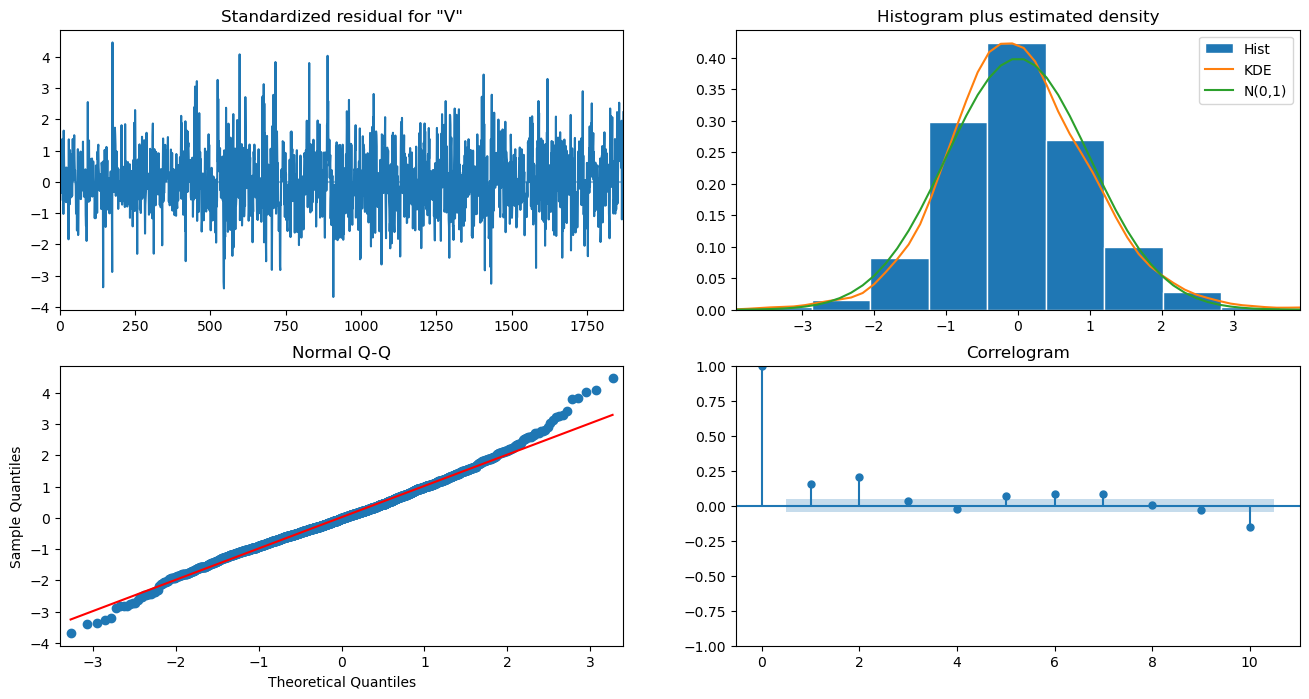

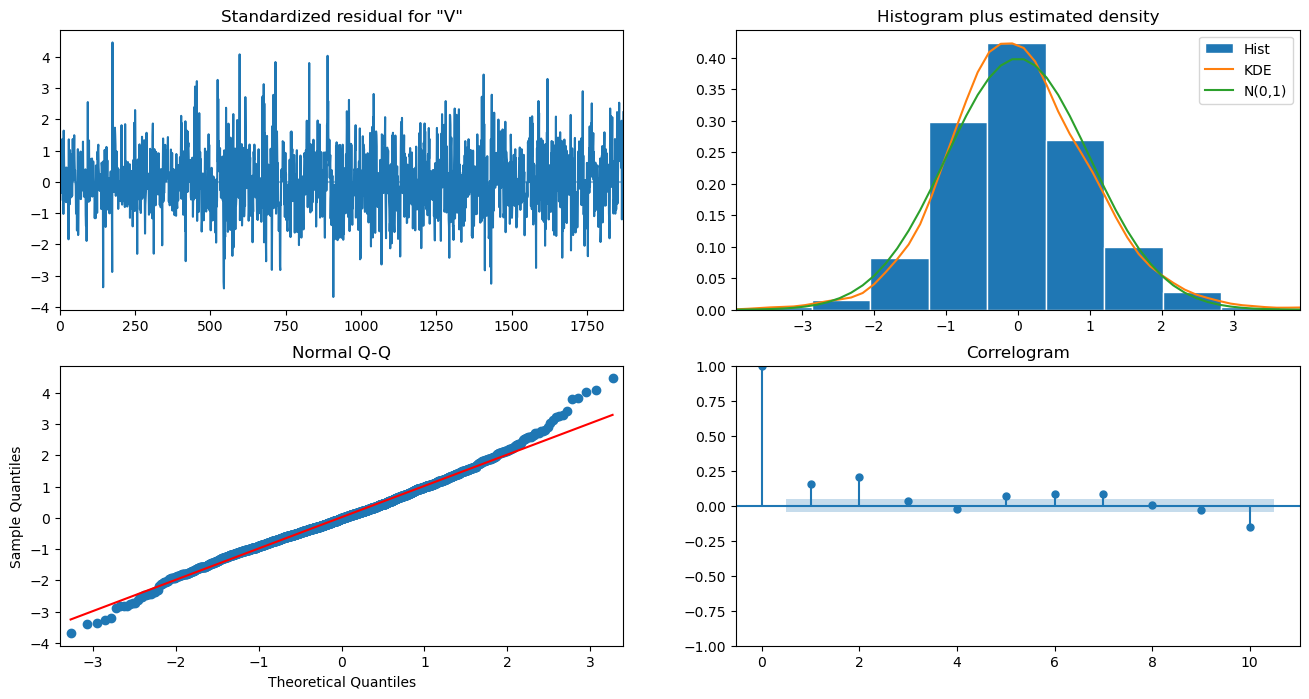

In [148]:
print(arimax_result.summary().tables[1])
arimax_result.plot_diagnostics(figsize=(16, 8))


In [149]:
# Forecast
forecast = arimax_result.get_forecast(steps=len(y_test), exog=exog_test)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, forecast_values))
mae = mean_absolute_error(y_test, forecast_values)
r2 = r2_score(y_test, forecast_values)

print("ARIMAX Metrics:")
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


ARIMAX Metrics:
RMSE: 2.3269, MAE: 2.0287, R²: 0.7092


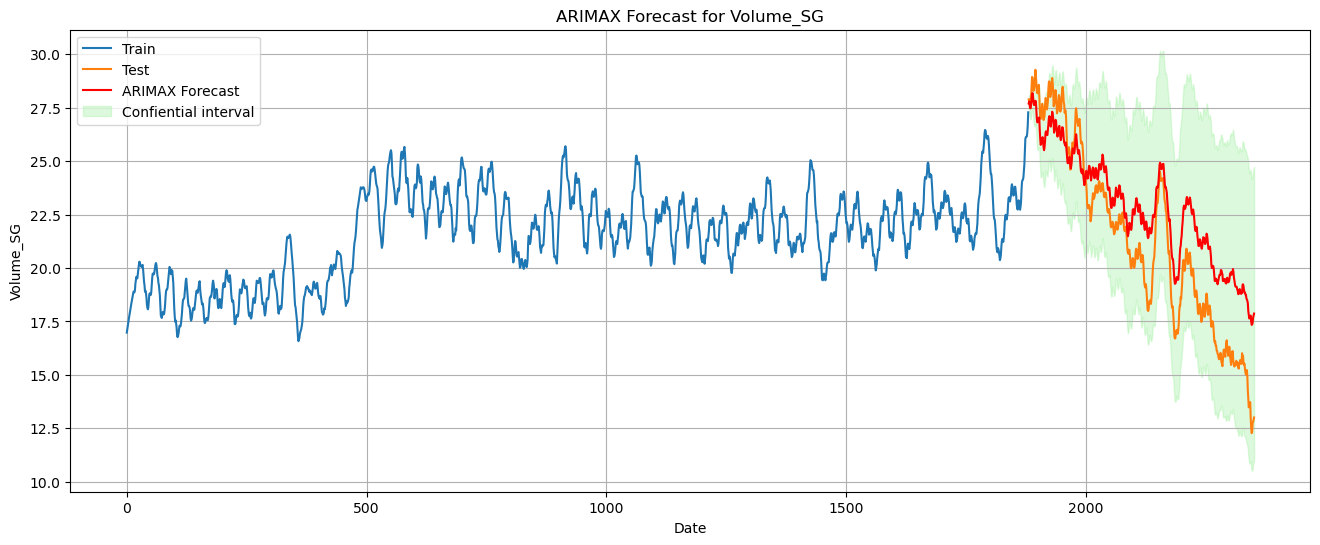

In [150]:

# ---------------------------
# Plot forecast
# ---------------------------
plt.figure(figsize=(16,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, forecast_values, color='red', label='ARIMAX Forecast')
plt.fill_between(y_test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='lightgreen',label='Confiential interval', alpha=0.3)
plt.title("ARIMAX Forecast for Volume_SG")
plt.xlabel("Date")
plt.ylabel("Volume_SG")
plt.legend()
plt.grid(True)
plt.show()

# b. LSTM


In [151]:
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
history_lstm = lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64,
                              validation_data=(X_test_seq, y_test_seq), verbose=1)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0867 - val_loss: 0.1335
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0124 - val_loss: 0.1034
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0094 - val_loss: 0.0831
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079 - val_loss: 0.0651
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062 - val_loss: 0.0621
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0051 - val_loss: 0.0519
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039 - val_loss: 0.0437
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0037 - val_loss: 0.0418
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034 - val_loss: 0.0347
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - val_loss: 0.0253
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028 - val_loss: 0.0210
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

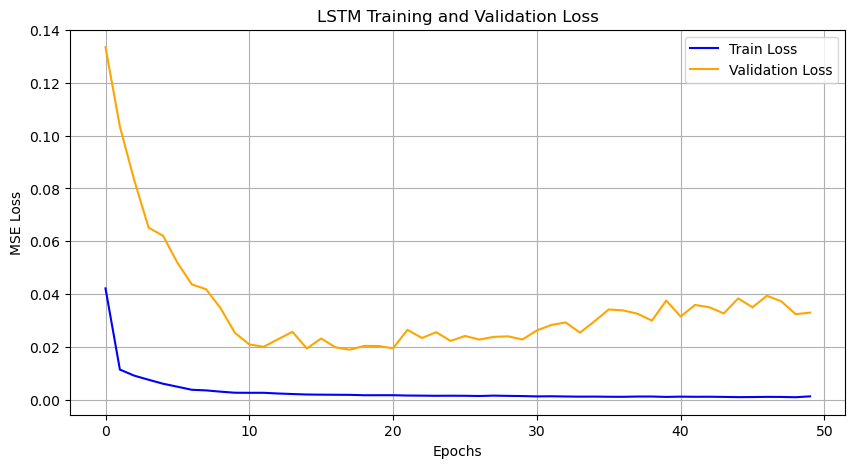

In [152]:
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history['loss'], label='Train Loss', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='orange')
plt.title("LSTM Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [153]:
y_pred_lstm = lstm_model.predict(X_test_seq)
# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
mae_lstm  = mean_absolute_error(y_test_seq, y_pred_lstm)
r2_lstm   = r2_score(y_test_seq, y_pred_lstm)


print(f"LSTM Test Metrics:\nRMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}, R²: {r2_lstm:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
LSTM Test Metrics:
RMSE: 0.1816, MAE: 0.1439, R²: 0.7720


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


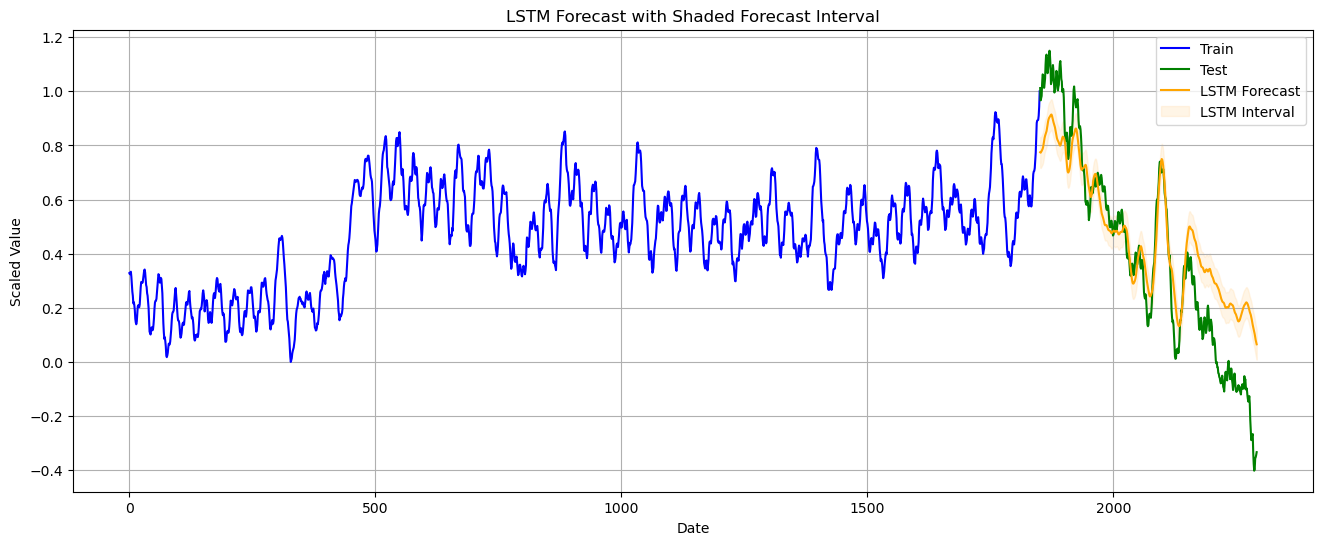

In [154]:
# Flatten all arrays to 1D
y_train_seq = y_train_seq.flatten()
y_test_seq  = y_test_seq.flatten()
y_pred_lstm = y_pred_lstm.flatten()


# Compute residuals on train sequences
residuals_lstm = y_train_seq - lstm_model.predict(X_train_seq).flatten()
rolling_std_lstm = np.std(residuals_lstm)

# Confidence interval bounds
upper_bound_lstm = y_pred_lstm + 2 * rolling_std_lstm
lower_bound_lstm = y_pred_lstm - 2 * rolling_std_lstm

# Prepare indices for plotting
train_index = merged_df.index[:len(y_train_seq)]
test_index  = merged_df.index[len(y_train_seq):len(y_train_seq) + len(y_test_seq)]

# Plot
plt.figure(figsize=(16,6))
plt.plot(train_index, y_train_seq, label='Train', color='blue')
plt.plot(test_index, y_test_seq, label='Test', color='green')
plt.plot(test_index, y_pred_lstm, label='LSTM Forecast', color='orange')
plt.fill_between(test_index, lower_bound_lstm, upper_bound_lstm,
                 color='navajowhite', alpha=0.3, label='LSTM Interval')
plt.title("LSTM Forecast with Shaded Forecast Interval")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()


# d. GRU

In [155]:
#HELPING FUCTION 
def plot_rnn_forecast(model, X_train_seq, y_train_seq, X_test_seq, y_test_seq, dates, seq_length=30, model_name="LSTM"):
    # Predict
    y_pred_train = model.predict(X_train_seq).flatten()
    y_pred_test  = model.predict(X_test_seq).flatten()
    
    # Flatten sequences if needed
    y_train_seq = y_train_seq.flatten()
    y_test_seq  = y_test_seq.flatten()
    
    # Compute residuals on train
    residuals = y_train_seq - y_pred_train
    rolling_std = np.std(residuals)
    
    # Confidence interval
    upper_bound = y_pred_test + 2 * rolling_std
    lower_bound = y_pred_test - 2 * rolling_std
    
    # Indices for plotting
    train_index = dates[seq_length:seq_length+len(y_train_seq)]
    test_index  = dates[seq_length+len(y_train_seq):seq_length+len(y_train_seq)+len(y_test_seq)]
    
    # Plot
    plt.figure(figsize=(16,6))
    plt.plot(train_index, y_train_seq, label='Train', color='blue')
    plt.plot(test_index, y_test_seq, label='Test', color='green')
    plt.plot(test_index, y_pred_test, label=f'{model_name} Forecast', color='orange')
    plt.fill_between(test_index, lower_bound, upper_bound, color='navajowhite', alpha=0.3, label=f'{model_name} Interval')
    plt.title(f"{model_name} Forecast with Shaded Forecast Interval")
    plt.xlabel("Date")
    plt.ylabel("Scaled Value")
    plt.legend()
    plt.grid(True)
    plt.show()



In [156]:
from tensorflow.keras.layers import GRU

gru_model = Sequential([
    GRU(64, activation='tanh', return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    GRU(32, activation='tanh'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')

history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50, batch_size=64, verbose=1
)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1209 - val_loss: 0.1563
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0163 - val_loss: 0.1040
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0110 - val_loss: 0.0764
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0088 - val_loss: 0.0536
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0071 - val_loss: 0.0413
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0066 - val_loss: 0.0268
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - val_loss: 0.0190
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0051 - val_loss: 0.0201
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049 - val_loss: 0.0151
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0041 - val_loss: 0.0149
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0039 - val_loss: 0.0153
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

In [157]:
# Predict
y_pred_gru = gru_model.predict(X_test_seq)

# Metrics
rmse_gru = np.sqrt(mean_squared_error(y_test_seq, y_pred_gru))
mae_gru  = mean_absolute_error(y_test_seq, y_pred_gru)
r2_gru   = r2_score(y_test_seq, y_pred_gru)
print(f"GRU Test Metrics: RMSE={rmse_gru:.4f}, MAE={mae_gru:.4f}, R²={r2_gru:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
GRU Test Metrics: RMSE=0.0916, MAE=0.0718, R²=0.9420


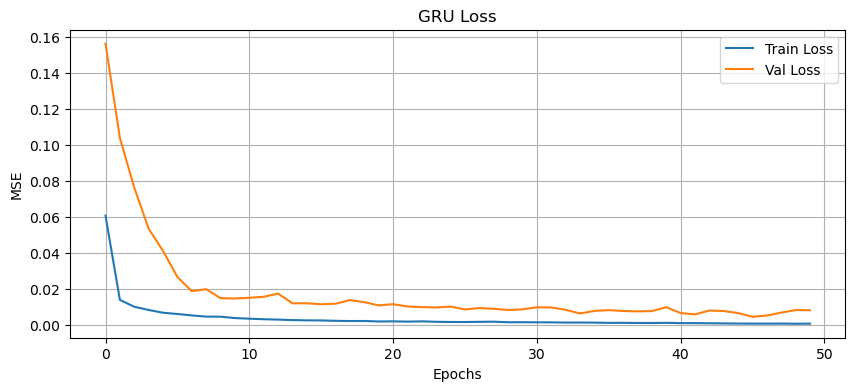

In [158]:
# Loss plot
plt.figure(figsize=(10,4))
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title("GRU Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


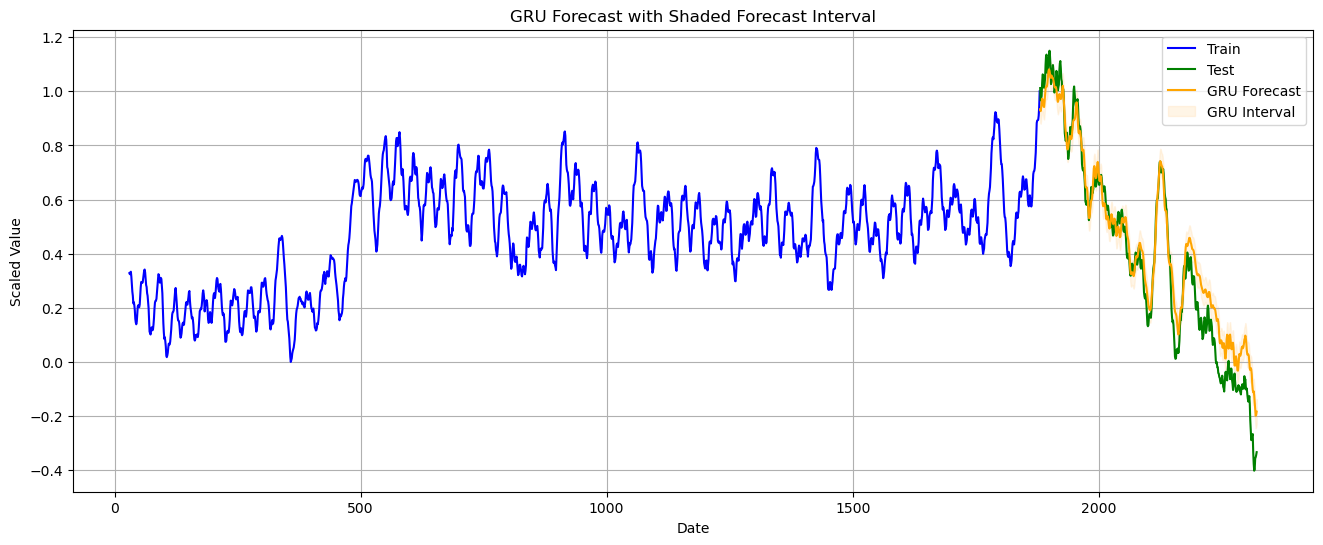

In [159]:
#  GRU
plot_rnn_forecast(
    model=gru_model,
    X_train_seq=X_train_seq,
    y_train_seq=y_train_seq,
    X_test_seq=X_test_seq,
    y_test_seq=y_test_seq,
    dates=merged_df.index,
    seq_length=seq_length,
    model_name="GRU"
)

# C. Bi-GRU

In [160]:
from tensorflow.keras.layers import Bidirectional

bigru_model = Sequential([
    Bidirectional(GRU(64, activation='tanh', return_sequences=True), input_shape=input_shape),
    Dropout(0.2),
    GRU(32, activation='tanh'),
    Dense(1)
])

bigru_model.compile(optimizer='adam', loss='mse')
history_bigru = bigru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50, batch_size=64, verbose=1
)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.1504 - val_loss: 0.1146
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0156 - val_loss: 0.0646
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0089 - val_loss: 0.0382
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0070 - val_loss: 0.0233
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0055 - val_loss: 0.0143
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0048 - val_loss: 0.0127
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0051 - val_loss: 0.0096
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0043 - val_loss: 0.0095
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0043 - val_loss: 0.0093
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036 - val_loss: 0.0079
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0036 - val_loss: 0.0073
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

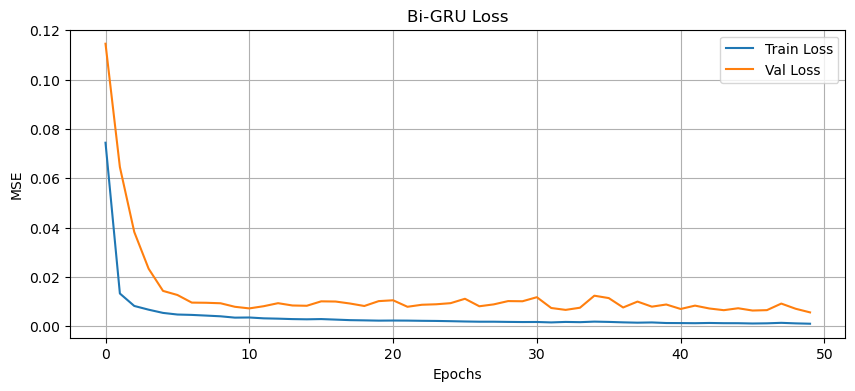

In [161]:
 #Loss plot
plt.figure(figsize=(10,4))
plt.plot(history_bigru.history['loss'], label='Train Loss')
plt.plot(history_bigru.history['val_loss'], label='Val Loss')
plt.title("Bi-GRU Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

In [162]:
# Predict
y_pred_bigru = bigru_model.predict(X_test_seq)

# Metrics
rmse_bigru = np.sqrt(mean_squared_error(y_test_seq, y_pred_bigru))
mae_bigru  = mean_absolute_error(y_test_seq, y_pred_bigru)
r2_bigru   = r2_score(y_test_seq, y_pred_bigru)
print(f"Bi-GRU Test Metrics: RMSE={rmse_bigru:.4f}, MAE={mae_bigru:.4f}, R²={r2_bigru:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Bi-GRU Test Metrics: RMSE=0.0751, MAE=0.0625, R²=0.9611


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


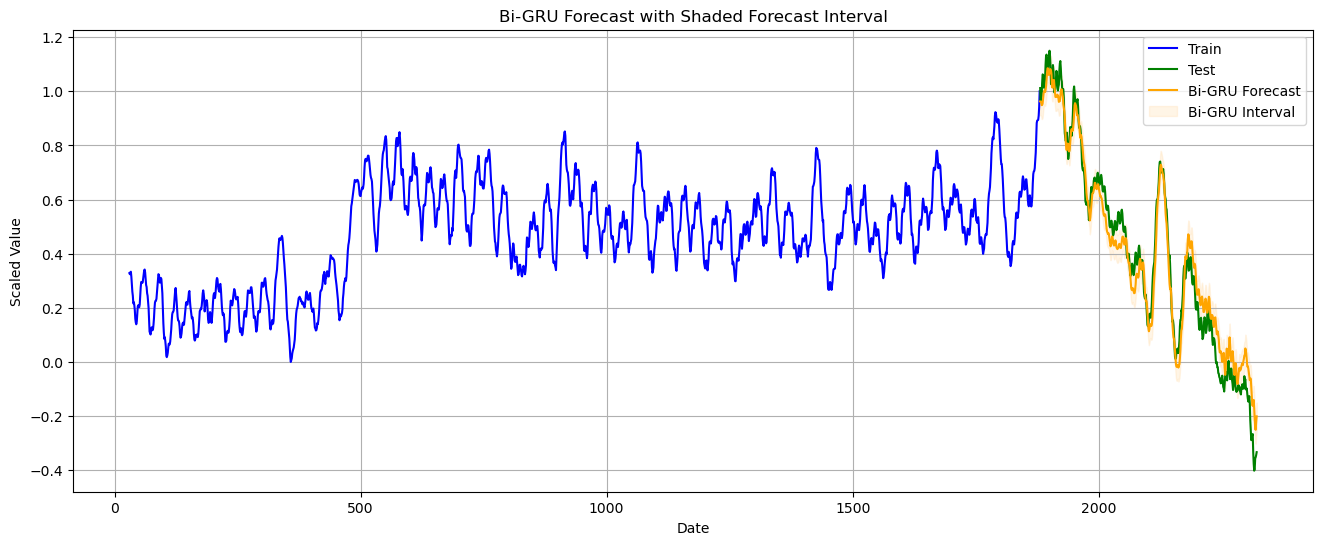

In [163]:
#Bi-GRU
plot_rnn_forecast(
    model=bigru_model,
    X_train_seq=X_train_seq,
    y_train_seq=y_train_seq,
    X_test_seq=X_test_seq,
    y_test_seq=y_test_seq,
    dates=merged_df.index,
    seq_length=seq_length,
    model_name="Bi-GRU"
)

In [164]:
# Combine with ARIMAX
metrics_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'GRU', 'BiGRU'],
    'RMSE': [rmse, rmse_lstm, rmse_gru, rmse_bigru],
    'MAE': [mae, mae_lstm, mae_gru, mae_bigru],
    'R²': [r2, r2_lstm, r2_gru, r2_bigru]
})
metrics_df


Model      RMSE       MAE        R²
0  ARIMAX  2.326890  2.028672  0.709217
1    LSTM  0.181598  0.143869  0.772026
2     GRU  0.091596  0.071797  0.942002
3   BiGRU  0.075058  0.062537  0.961055

In [166]:
import plotly.graph_objects as go
import numpy as np

# ---------------------------
# Predictions
# ---------------------------
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()
y_pred_gru = gru_model.predict(X_test_seq).flatten()
y_pred_bigru = bigru_model.predict(X_test_seq).flatten()
#y_pred_arimax = forecast_values.values if hasattr(forecast_values, 'values') else forecast_values

# ---------------------------
# Compute rolling residuals for intervals
# ---------------------------
rolling_std_lstm = np.std(y_train_seq.flatten() - lstm_model.predict(X_train_seq).flatten())
rolling_std_gru = np.std(y_train_seq.flatten() - gru_model.predict(X_train_seq).flatten())
rolling_std_bigru = np.std(y_train_seq.flatten() - bigru_model.predict(X_train_seq).flatten())

upper_lstm = y_pred_lstm + 2*rolling_std_lstm
lower_lstm = y_pred_lstm - 2*rolling_std_lstm

upper_gru = y_pred_gru + 2*rolling_std_gru
lower_gru = y_pred_gru - 2*rolling_std_gru

upper_bigru = y_pred_bigru + 2*rolling_std_bigru
lower_bigru = y_pred_bigru - 2*rolling_std_bigru

# ---------------------------
# Time index
# ---------------------------
train_idx = merged_df.index[:len(y_train_seq)]
test_idx = merged_df.index[len(y_train_seq):len(y_train_seq)+len(y_test_seq)]

# ---------------------------
# Plot
# ---------------------------
fig = go.Figure()

# Train
fig.add_trace(go.Scatter(x=train_idx, y=y_train_seq.flatten(),
                         mode='lines', name='Train', line=dict(color='blue')))

# Test
fig.add_trace(go.Scatter(x=test_idx, y=y_test_seq.flatten(),
                         mode='lines', name='Test', line=dict(color='black')))

'''# ARIMAX Forecast + CI
conf_int_lower = conf_int.iloc[:,0].values
conf_int_upper = conf_int.iloc[:,1].values

fig.add_trace(go.Scatter(x=test_idx, y=y_pred_arimax,
                         mode='lines', name='ARIMAX Forecast', line=dict(color='red')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_idx, test_idx[::-1]]),
    y=np.concatenate([conf_int_upper, conf_int_lower[::-1]]),
    fill='toself', fillcolor='rgba(255,0,0,0.2)', line=dict(color='rgba(255,0,0,0)'),
    hoverinfo="skip", showlegend=True, name='ARIMAX Interval'
))'''

# LSTM Forecast + Interval
fig.add_trace(go.Scatter(x=test_idx, y=y_pred_lstm,
                         mode='lines', name='LSTM Forecast', line=dict(color='orange')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_idx, test_idx[::-1]]),
    y=np.concatenate([upper_lstm, lower_lstm[::-1]]),
    fill='toself', fillcolor='rgba(255,165,0,0.2)', line=dict(color='rgba(255,165,0,0)'),
    hoverinfo="skip", showlegend=True, name='LSTM Interval'
))

# GRU Forecast + Interval
fig.add_trace(go.Scatter(x=test_idx, y=y_pred_gru,
                         mode='lines', name='GRU Forecast', line=dict(color='green')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_idx, test_idx[::-1]]),
    y=np.concatenate([upper_gru, lower_gru[::-1]]),
    fill='toself', fillcolor='rgba(0,128,0,0.2)', line=dict(color='rgba(0,128,0,0)'),
    hoverinfo="skip", showlegend=True, name='GRU Interval'
))

# BiGRU Forecast + Interval
fig.add_trace(go.Scatter(x=test_idx, y=y_pred_bigru,
                         mode='lines', name='BiGRU Forecast', line=dict(color='purple')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_idx, test_idx[::-1]]),
    y=np.concatenate([upper_bigru, lower_bigru[::-1]]),
    fill='toself', fillcolor='rgba(128,0,128,0.2)', line=dict(color='rgba(128,0,128,0)'),
    hoverinfo="skip", showlegend=True, name='BiGRU Interval'
))

# ---------------------------
# Layout
# ---------------------------
fig.update_layout(
    title='Forecast Comparison: ARIMAX vs LSTM/GRU/BiGRU with Confidence Intervals',
    xaxis_title='Date',
    yaxis_title='Value',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
